In [22]:
import pandas as pd
import warnings
from pathlib import Path
from tqdm.notebook import tqdm
from neuron_morphology.swc_io import morphology_from_swc
from neuron_morphology.constants import AXON, BASAL_DENDRITE, SOMA
import matplotlib.pyplot as plt
import seaborn as sns
from neuron_morphology.feature_extractor.data import Data
from neuron_morphology.feature_extractor.feature_extractor import FeatureExtractor
from neuron_morphology.features.default_features import default_features
import numpy as np
from neuron_morphology.feature_extractor.utilities import unnest
import logging
import pickle

from neurom import load_neuron
from neurom.view import view
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2
#
# import sys
# sys.path.append('/opt/data/Cell/')
# %cd Cell

# Download data

In [23]:
id_m = pd.read_csv('id_L5_M.csv')
id_m.head()

,cell_specimen_id,neuron_reconstruction_type,ephys_session_id,transcriptomics_sample_id
0,601790961,full,601790945,PS0817_E1-50_S19
1,601808698,full,601808619,PS0817_E1-50_S26
2,602231708,full,602231628,PS0817_E1-50_S46
3,626153003,full,626152964,SM-GE62S_S126_E1-50
4,639674270,full,639674215,SM-GE63H_S142_E1-50


In [24]:
all_meta_df = pd.read_csv('20200711_patchseq_metadata_mouse.csv')
me_meta_df = id_m.merge(all_meta_df, how='left')
me_meta_df

,cell_specimen_id,neuron_reconstruction_type,ephys_session_id,transcriptomics_sample_id,project,cell_specimen_name,hemisphere,structure,donor_id,donor_name,...,ethnicity,medical_conditions,full_genotype,dendrite_type,apical_dendrite_status,cell_soma_normalized_depth,depth_from_pia_um,transcriptomics_batch,Tree_first_cl_label,Unnamed: 21
0,601790961,full,601790945,PS0817_E1-50_S19,mIVSCC-MET,Sst-IRES-Cre;Ai14-331663.04.01.01,left,VISpm5,331663,Sst-IRES-Cre;Ai14-331663,...,NaN,NaN,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt,aspiny,NaN,0.621829,NaN,BT036,CS180626100041,Sst Tac2 Myh4
1,601808698,full,601808619,PS0817_E1-50_S26,mIVSCC-MET,Sst-IRES-Cre;Ai14-331663.04.02.03,right,VISp5,331663,Sst-IRES-Cre;Ai14-331663,...,NaN,NaN,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt,aspiny,NaN,0.483030,NaN,BT036,CS180626100043,Sst Hpse Cbln4
2,602231708,full,602231628,PS0817_E1-50_S46,mIVSCC-MET,Sst-IRES-Cre;Ai14-331660.06.02.01,right,VISp5,331660,Sst-IRES-Cre;Ai14-331660,...,NaN,NaN,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt,aspiny,NaN,0.589005,NaN,BT036,CS180626100035,Sst Calb2 Pdlim5
3,626153003,full,626152964,SM-GE62S_S126_E1-50,mIVSCC-MET,Sst-IRES-Cre;Ai14-346783.03.02.01,right,VISp5,346783,Sst-IRES-Cre;Ai14-346783,...,NaN,NaN,Sst-IRES-Cre/wt;Ai14(RCL-tdT)/wt,aspiny,NaN,0.684142,NaN,RSC-122,CS180626100043,Sst Hpse Cbln4
4,639674270,full,639674215,SM-GE63H_S142_E1-50,mIVSCC-MET,Chrna2-Cre_OE25;Ai14-351067.04.02.01,right,VISp5,351067,Chrna2-Cre_OE25;Ai14-351067,...,NaN,NaN,Chrna2-Cre_OE25/wt;Ai14(RCL-tdT)/wt,aspiny,NaN,0.767271,NaN,RSC-125,CS180626100019,Vip Lmo1 Fam159b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,863585604,full,863585508,SM-GE4RS_S067_E1-50,mIVSCC-MET,Chrna2-Cre_OE25;Sst-IRES-FlpO;Ai65-460584.03.0...,left,VISp5,460584,Chrna2-Cre_OE25;Sst-IRES-FlpO;Ai65-460584,...,NaN,NaN,Chrna2-Cre_OE25/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-...,aspiny,NaN,0.606798,NaN,RSC-211,CS180626100040,Sst Chrna2 Ptgdr
136,863631899,full,863631569,SM-GE4RS_S069_E1-50,mIVSCC-MET,Chrna2-Cre_OE25;Sst-IRES-FlpO;Ai65-460584.03.0...,left,VISp5,460584,Chrna2-Cre_OE25;Sst-IRES-FlpO;Ai65-460584,...,NaN,NaN,Chrna2-Cre_OE25/wt;Sst-IRES-FlpO/wt;Ai65(RCFL-...,aspiny,NaN,0.646295,NaN,RSC-211,CS180626100046,Sst Esm1
137,870661094,full,870660740,SM-GE4RI_S181_E1-50,mIVSCC-MET,Nkx2-1-CreERT2;Ai14-465339.04.02.01,right,VISp5,465339,Nkx2-1-CreERT2;Ai14-465339,...,NaN,NaN,Nkx2-1-CreERT2/wt;Ai14(RCL-tdT)/wt,aspiny,NaN,0.763634,NaN,RSC-213,CS180626100007,Lamp5 Lhx6
138,887288382,full,887288357,SM-GE4Y5_S111_E1-50,mIVSCC-MET,Htr3a-Cre_NO152;Ai14-468437.05.02.02,right,VISp5,468437,Htr3a-Cre_NO152;Ai14-468437,...,NaN,NaN,Htr3a-Cre_NO152/wt;Ai14(RCL-tdT)/wt,aspiny,NaN,0.548919,NaN,RSC-217,CS180626100025,Vip Chat Htr1f


## Download SWC files

In [4]:
def download_swc(specimen_id):
    """Download *.maker , *_raw.swc, *_transformed.swc abount a specimen_id."""
    url_base = 'https://download.brainlib.org/biccn/zeng/pseq/morph/200526/'
    marker_file_url = f'{url_base}{specimen_id}.marker'
    !wget {marker_file_url} -P swc
    raw_url = f'{url_base}{specimen_id}_raw.swc'
    !wget {raw_url} -P swc
    trans_url = f'{url_base}{specimen_id}_transformed.swc'
    !wget {trans_url} -P swc

In [19]:
for specimen_id in tqdm(id_m['cell_specimen_id']):
    download_swc(specimen_id)

  0%|          | 0/140 [00:00<?, ?it/s]

--2021-06-26 07:25:15--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/601790961.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327 [application/octet-stream]
Saving to: ‘swc/601790961.marker’

601790961.marker    100%[===================>]     327  --.-KB/s    in 0.001s  

2021-06-26 07:25:16 (561 KB/s) - ‘swc/601790961.marker’ saved [327/327]

--2021-06-26 07:25:17--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/601790961_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 551434 (539K) [application/octet-stream]
Saving to: ‘swc/601790961_raw.swc’

601790961_raw.swc   10

  1%|          | 1/140 [00:10<24:00, 10.36s/it]

--2021-06-26 07:25:25--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/601808698.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 320 [application/octet-stream]
Saving to: ‘swc/601808698.marker’

601808698.marker    100%[===================>]     320  --.-KB/s    in 0.001s  

2021-06-26 07:25:26 (363 KB/s) - ‘swc/601808698.marker’ saved [320/320]

--2021-06-26 07:25:27--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/601808698_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 608585 (594K) [application/octet-stream]
Saving to: ‘swc/601808698_raw.swc’

601808698_raw.swc   10

  1%|▏         | 2/140 [00:24<29:09, 12.68s/it]

--2021-06-26 07:25:40--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/602231708.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268 [application/octet-stream]
Saving to: ‘swc/602231708.marker’

602231708.marker    100%[===================>]     268  --.-KB/s    in 0.001s  

2021-06-26 07:25:41 (292 KB/s) - ‘swc/602231708.marker’ saved [268/268]

--2021-06-26 07:25:43--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/602231708_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315886 (308K) [application/octet-stream]
Saving to: ‘swc/602231708_raw.swc’

602231708_raw.swc   10

  2%|▏         | 3/140 [00:36<28:16, 12.38s/it]

--2021-06-26 07:25:51--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/626153003.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 590 [application/octet-stream]
Saving to: ‘swc/626153003.marker’

626153003.marker    100%[===================>]     590  --.-KB/s    in 0.001s  

2021-06-26 07:25:52 (679 KB/s) - ‘swc/626153003.marker’ saved [590/590]

--2021-06-26 07:25:53--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/626153003_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285707 (279K) [application/octet-stream]
Saving to: ‘swc/626153003_raw.swc’

626153003_raw.swc   10

  3%|▎         | 4/140 [00:46<25:57, 11.45s/it]

--2021-06-26 07:26:01--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639674270.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350 [application/octet-stream]
Saving to: ‘swc/639674270.marker’

639674270.marker    100%[===================>]     350  --.-KB/s    in 0.001s  

2021-06-26 07:26:02 (541 KB/s) - ‘swc/639674270.marker’ saved [350/350]

--2021-06-26 07:26:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639674270_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 288284 (282K) [application/octet-stream]
Saving to: ‘swc/639674270_raw.swc’

639674270_raw.swc   10

  4%|▎         | 5/140 [00:55<23:51, 10.60s/it]

--2021-06-26 07:26:11--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639708328.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325 [application/octet-stream]
Saving to: ‘swc/639708328.marker’

639708328.marker    100%[===================>]     325  --.-KB/s    in 0.001s  

2021-06-26 07:26:12 (340 KB/s) - ‘swc/639708328.marker’ saved [325/325]

--2021-06-26 07:26:14--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639708328_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285563 (279K) [application/octet-stream]
Saving to: ‘swc/639708328_raw.swc’

639708328_raw.swc   10

  4%|▍         | 6/140 [01:08<25:07, 11.25s/it]

--2021-06-26 07:26:24--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639862877.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261 [application/octet-stream]
Saving to: ‘swc/639862877.marker’

639862877.marker    100%[===================>]     261  --.-KB/s    in 0.001s  

2021-06-26 07:26:25 (223 KB/s) - ‘swc/639862877.marker’ saved [261/261]

--2021-06-26 07:26:26--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639862877_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 720160 (703K) [application/octet-stream]
Saving to: ‘swc/639862877_raw.swc’

639862877_raw.swc   10

  5%|▌         | 7/140 [01:46<44:39, 20.15s/it]

--2021-06-26 07:27:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639881631.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379 [application/octet-stream]
Saving to: ‘swc/639881631.marker’

639881631.marker    100%[===================>]     379  --.-KB/s    in 0.001s  

2021-06-26 07:27:03 (478 KB/s) - ‘swc/639881631.marker’ saved [379/379]

--2021-06-26 07:27:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/639881631_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412353 (403K) [application/octet-stream]
Saving to: ‘swc/639881631_raw.swc’

639881631_raw.swc   10

  6%|▌         | 8/140 [01:57<37:48, 17.18s/it]

--2021-06-26 07:27:13--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/640061596.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484 [application/octet-stream]
Saving to: ‘swc/640061596.marker’

640061596.marker    100%[===================>]     484  --.-KB/s    in 0.001s  

2021-06-26 07:27:15 (487 KB/s) - ‘swc/640061596.marker’ saved [484/484]

--2021-06-26 07:27:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/640061596_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218347 (213K) [application/octet-stream]
Saving to: ‘swc/640061596_raw.swc’

640061596_raw.swc   10

  6%|▋         | 9/140 [02:08<33:06, 15.16s/it]

--2021-06-26 07:27:23--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/643536919.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330 [application/octet-stream]
Saving to: ‘swc/643536919.marker’

643536919.marker    100%[===================>]     330  --.-KB/s    in 0.001s  

2021-06-26 07:27:24 (338 KB/s) - ‘swc/643536919.marker’ saved [330/330]

--2021-06-26 07:27:26--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/643536919_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316765 (309K) [application/octet-stream]
Saving to: ‘swc/643536919_raw.swc’

643536919_raw.swc   10

  7%|▋         | 10/140 [02:20<30:59, 14.31s/it]

--2021-06-26 07:27:36--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/643702874.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 431 [application/octet-stream]
Saving to: ‘swc/643702874.marker’

643702874.marker    100%[===================>]     431  --.-KB/s    in 0.001s  

2021-06-26 07:27:38 (442 KB/s) - ‘swc/643702874.marker’ saved [431/431]

--2021-06-26 07:27:39--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/643702874_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207341 (202K) [application/octet-stream]
Saving to: ‘swc/643702874_raw.swc’

643702874_raw.swc   10

  8%|▊         | 11/140 [02:36<31:54, 14.84s/it]

--2021-06-26 07:27:52--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/643754730.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109 [application/octet-stream]
Saving to: ‘swc/643754730.marker’

643754730.marker    100%[===================>]     109  --.-KB/s    in 0.001s  

2021-06-26 07:27:54 (152 KB/s) - ‘swc/643754730.marker’ saved [109/109]

--2021-06-26 07:27:55--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/643754730_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224017 (219K) [application/octet-stream]
Saving to: ‘swc/643754730_raw.swc’

643754730_raw.swc   10

  9%|▊         | 12/140 [02:46<28:32, 13.38s/it]

--2021-06-26 07:28:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/644994103.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 269 [application/octet-stream]
Saving to: ‘swc/644994103.marker’

644994103.marker    100%[===================>]     269  --.-KB/s    in 0.001s  

2021-06-26 07:28:03 (271 KB/s) - ‘swc/644994103.marker’ saved [269/269]

--2021-06-26 07:28:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/644994103_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 472983 (462K) [application/octet-stream]
Saving to: ‘swc/644994103_raw.swc’

644994103_raw.swc   10

  9%|▉         | 13/140 [03:19<40:24, 19.09s/it]

--2021-06-26 07:28:34--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/645012440.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218 [application/octet-stream]
Saving to: ‘swc/645012440.marker’

645012440.marker    100%[===================>]     218  --.-KB/s    in 0.001s  

2021-06-26 07:28:35 (292 KB/s) - ‘swc/645012440.marker’ saved [218/218]

--2021-06-26 07:28:37--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/645012440_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263532 (257K) [application/octet-stream]
Saving to: ‘swc/645012440_raw.swc’

645012440_raw.swc   10

 10%|█         | 14/140 [03:35<38:19, 18.25s/it]

--2021-06-26 07:28:50--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/645057881.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273 [application/octet-stream]
Saving to: ‘swc/645057881.marker’

645057881.marker    100%[===================>]     273  --.-KB/s    in 0.001s  

2021-06-26 07:28:51 (250 KB/s) - ‘swc/645057881.marker’ saved [273/273]

--2021-06-26 07:28:53--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/645057881_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 398663 (389K) [application/octet-stream]
Saving to: ‘swc/645057881_raw.swc’

645057881_raw.swc   10

 11%|█         | 15/140 [03:46<33:46, 16.21s/it]

--2021-06-26 07:29:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/645322005.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435 [application/octet-stream]
Saving to: ‘swc/645322005.marker’

645322005.marker    100%[===================>]     435  --.-KB/s    in 0.001s  

2021-06-26 07:29:03 (456 KB/s) - ‘swc/645322005.marker’ saved [435/435]

--2021-06-26 07:29:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/645322005_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550865 (538K) [application/octet-stream]
Saving to: ‘swc/645322005_raw.swc’

645322005_raw.swc   10

 11%|█▏        | 16/140 [03:59<31:06, 15.05s/it]

--2021-06-26 07:29:14--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/646805498.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221 [application/octet-stream]
Saving to: ‘swc/646805498.marker’

646805498.marker    100%[===================>]     221  --.-KB/s    in 0.001s  

2021-06-26 07:29:16 (258 KB/s) - ‘swc/646805498.marker’ saved [221/221]

--2021-06-26 07:29:17--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/646805498_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607133 (593K) [application/octet-stream]
Saving to: ‘swc/646805498_raw.swc’

646805498_raw.swc   10

 12%|█▏        | 17/140 [04:27<39:02, 19.05s/it]

--2021-06-26 07:29:43--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/646852171.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 214 [application/octet-stream]
Saving to: ‘swc/646852171.marker’

646852171.marker    100%[===================>]     214  --.-KB/s    in 0.001s  

2021-06-26 07:29:44 (242 KB/s) - ‘swc/646852171.marker’ saved [214/214]

--2021-06-26 07:29:45--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/646852171_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445371 (435K) [application/octet-stream]
Saving to: ‘swc/646852171_raw.swc’

646852171_raw.swc   10

 13%|█▎        | 18/140 [04:44<37:27, 18.43s/it]

--2021-06-26 07:29:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/649387261.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217 [application/octet-stream]
Saving to: ‘swc/649387261.marker’

649387261.marker    100%[===================>]     217  --.-KB/s    in 0.001s  

2021-06-26 07:30:00 (286 KB/s) - ‘swc/649387261.marker’ saved [217/217]

--2021-06-26 07:30:01--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/649387261_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517279 (505K) [application/octet-stream]
Saving to: ‘swc/649387261_raw.swc’

649387261_raw.swc   10

 14%|█▎        | 19/140 [05:06<39:27, 19.57s/it]

--2021-06-26 07:30:21--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/652533530.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495 [application/octet-stream]
Saving to: ‘swc/652533530.marker’

652533530.marker    100%[===================>]     495  --.-KB/s    in 0.001s  

2021-06-26 07:30:23 (448 KB/s) - ‘swc/652533530.marker’ saved [495/495]

--2021-06-26 07:30:24--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/652533530_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 703532 (687K) [application/octet-stream]
Saving to: ‘swc/652533530_raw.swc’

652533530_raw.swc   10

 14%|█▍        | 20/140 [06:03<1:01:12, 30.60s/it]

--2021-06-26 07:31:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/653699672.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407 [application/octet-stream]
Saving to: ‘swc/653699672.marker’

653699672.marker    100%[===================>]     407  --.-KB/s    in 0.001s  

2021-06-26 07:31:19 (377 KB/s) - ‘swc/653699672.marker’ saved [407/407]

--2021-06-26 07:31:20--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/653699672_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 478933 (468K) [application/octet-stream]
Saving to: ‘swc/653699672_raw.swc’

653699672_raw.swc   10

 15%|█▌        | 21/140 [06:38<1:03:49, 32.18s/it]

--2021-06-26 07:31:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/656156755.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 430 [application/octet-stream]
Saving to: ‘swc/656156755.marker’

656156755.marker    100%[===================>]     430  --.-KB/s    in 0.001s  

2021-06-26 07:31:54 (663 KB/s) - ‘swc/656156755.marker’ saved [430/430]

--2021-06-26 07:31:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/656156755_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538893 (526K) [application/octet-stream]
Saving to: ‘swc/656156755_raw.swc’

656156755_raw.swc   10

 16%|█▌        | 22/140 [06:49<50:48, 25.84s/it]  

--2021-06-26 07:32:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/656901554.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274 [application/octet-stream]
Saving to: ‘swc/656901554.marker’

656901554.marker    100%[===================>]     274  --.-KB/s    in 0.001s  

2021-06-26 07:32:06 (364 KB/s) - ‘swc/656901554.marker’ saved [274/274]

--2021-06-26 07:32:08--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/656901554_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 302838 (296K) [application/octet-stream]
Saving to: ‘swc/656901554_raw.swc’

656901554_raw.swc   10

 16%|█▋        | 23/140 [07:19<52:40, 27.01s/it]

--2021-06-26 07:32:34--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657442490.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433 [application/octet-stream]
Saving to: ‘swc/657442490.marker’

657442490.marker    100%[===================>]     433  --.-KB/s    in 0.001s  

2021-06-26 07:32:35 (589 KB/s) - ‘swc/657442490.marker’ saved [433/433]

--2021-06-26 07:32:37--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657442490_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132734 (130K) [application/octet-stream]
Saving to: ‘swc/657442490_raw.swc’

657442490_raw.swc   10

 17%|█▋        | 24/140 [07:29<42:14, 21.85s/it]

--2021-06-26 07:32:44--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657661984.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111 [application/octet-stream]
Saving to: ‘swc/657661984.marker’

657661984.marker    100%[===================>]     111  --.-KB/s    in 0.001s  

2021-06-26 07:32:45 (117 KB/s) - ‘swc/657661984.marker’ saved [111/111]

--2021-06-26 07:32:46--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657661984_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488428 (477K) [application/octet-stream]
Saving to: ‘swc/657661984_raw.swc’

657661984_raw.swc   10

 18%|█▊        | 25/140 [08:00<46:56, 24.49s/it]

--2021-06-26 07:33:15--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657857340.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111 [application/octet-stream]
Saving to: ‘swc/657857340.marker’

657857340.marker    100%[===================>]     111  --.-KB/s    in 0.001s  

2021-06-26 07:33:16 (161 KB/s) - ‘swc/657857340.marker’ saved [111/111]

--2021-06-26 07:33:17--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657857340_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 752889 (735K) [application/octet-stream]
Saving to: ‘swc/657857340_raw.swc’

657857340_raw.swc   10

 19%|█▊        | 26/140 [08:18<43:07, 22.70s/it]

--2021-06-26 07:33:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657858349.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110 [application/octet-stream]
Saving to: ‘swc/657858349.marker’

657858349.marker    100%[===================>]     110  --.-KB/s    in 0.001s  

2021-06-26 07:33:34 (146 KB/s) - ‘swc/657858349.marker’ saved [110/110]

--2021-06-26 07:33:36--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/657858349_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178723 (175K) [application/octet-stream]
Saving to: ‘swc/657858349_raw.swc’

657858349_raw.swc   10

 19%|█▉        | 27/140 [08:27<34:35, 18.37s/it]

--2021-06-26 07:33:42--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/659405820.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263 [application/octet-stream]
Saving to: ‘swc/659405820.marker’

659405820.marker    100%[===================>]     263  --.-KB/s    in 0.001s  

2021-06-26 07:33:43 (285 KB/s) - ‘swc/659405820.marker’ saved [263/263]

--2021-06-26 07:33:45--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/659405820_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358215 (350K) [application/octet-stream]
Saving to: ‘swc/659405820_raw.swc’

659405820_raw.swc   10

 20%|██        | 28/140 [08:47<35:38, 19.10s/it]

--2021-06-26 07:34:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/660050258.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335 [application/octet-stream]
Saving to: ‘swc/660050258.marker’

660050258.marker    100%[===================>]     335  --.-KB/s    in 0.001s  

2021-06-26 07:34:03 (410 KB/s) - ‘swc/660050258.marker’ saved [335/335]

--2021-06-26 07:34:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/660050258_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198547 (194K) [application/octet-stream]
Saving to: ‘swc/660050258_raw.swc’

660050258_raw.swc   10

 21%|██        | 29/140 [09:05<34:33, 18.68s/it]

--2021-06-26 07:34:20--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/661189529.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223 [application/octet-stream]
Saving to: ‘swc/661189529.marker’

661189529.marker    100%[===================>]     223  --.-KB/s    in 0.001s  

2021-06-26 07:34:21 (309 KB/s) - ‘swc/661189529.marker’ saved [223/223]

--2021-06-26 07:34:22--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/661189529_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 455932 (445K) [application/octet-stream]
Saving to: ‘swc/661189529_raw.swc’

661189529_raw.swc   10

 21%|██▏       | 30/140 [09:48<47:28, 25.89s/it]

--2021-06-26 07:35:03--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/661492805.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217 [application/octet-stream]
Saving to: ‘swc/661492805.marker’

661492805.marker    100%[===================>]     217  --.-KB/s    in 0.001s  

2021-06-26 07:35:04 (286 KB/s) - ‘swc/661492805.marker’ saved [217/217]

--2021-06-26 07:35:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/661492805_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638026 (623K) [application/octet-stream]
Saving to: ‘swc/661492805_raw.swc’

661492805_raw.swc   10

 22%|██▏       | 31/140 [09:58<38:18, 21.09s/it]

--2021-06-26 07:35:13--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/663193112.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167 [application/octet-stream]
Saving to: ‘swc/663193112.marker’

663193112.marker    100%[===================>]     167  --.-KB/s    in 0.001s  

2021-06-26 07:35:14 (182 KB/s) - ‘swc/663193112.marker’ saved [167/167]

--2021-06-26 07:35:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/663193112_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350715 (342K) [application/octet-stream]
Saving to: ‘swc/663193112_raw.swc’

663193112_raw.swc   10

 23%|██▎       | 32/140 [10:23<40:13, 22.35s/it]

--2021-06-26 07:35:38--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/669047778.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109 [application/octet-stream]
Saving to: ‘swc/669047778.marker’

669047778.marker    100%[===================>]     109  --.-KB/s    in 0.002s  

2021-06-26 07:35:39 (57.1 KB/s) - ‘swc/669047778.marker’ saved [109/109]

--2021-06-26 07:35:40--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/669047778_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280441 (274K) [application/octet-stream]
Saving to: ‘swc/669047778_raw.swc’

669047778_raw.swc   1

 24%|██▎       | 33/140 [10:44<39:00, 21.88s/it]

--2021-06-26 07:35:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/669165397.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 652 [application/octet-stream]
Saving to: ‘swc/669165397.marker’

669165397.marker    100%[===================>]     652  --.-KB/s    in 0.001s  

2021-06-26 07:36:00 (778 KB/s) - ‘swc/669165397.marker’ saved [652/652]

--2021-06-26 07:36:01--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/669165397_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 356355 (348K) [application/octet-stream]
Saving to: ‘swc/669165397_raw.swc’

669165397_raw.swc   10

 24%|██▍       | 34/140 [11:12<42:15, 23.92s/it]

--2021-06-26 07:36:28--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/669838950.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161 [application/octet-stream]
Saving to: ‘swc/669838950.marker’

669838950.marker    100%[===================>]     161  --.-KB/s    in 0.001s  

2021-06-26 07:36:29 (167 KB/s) - ‘swc/669838950.marker’ saved [161/161]

--2021-06-26 07:36:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/669838950_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272723 (266K) [application/octet-stream]
Saving to: ‘swc/669838950_raw.swc’

669838950_raw.swc   100%[===================>] 266.33K

 25%|██▌       | 35/140 [11:38<42:58, 24.56s/it]

--2021-06-26 07:36:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/670340941.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222 [application/octet-stream]
Saving to: ‘swc/670340941.marker’

670340941.marker    100%[===================>]     222  --.-KB/s    in 0.001s  

2021-06-26 07:36:55 (286 KB/s) - ‘swc/670340941.marker’ saved [222/222]

--2021-06-26 07:36:57--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/670340941_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258959 (253K) [application/octet-stream]
Saving to: ‘swc/670340941_raw.swc’

670340941_raw.swc   100%[===================>] 252.89K

 26%|██▌       | 36/140 [12:03<42:27, 24.50s/it]

--2021-06-26 07:37:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/673395815.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166 [application/octet-stream]
Saving to: ‘swc/673395815.marker’

673395815.marker    100%[===================>]     166  --.-KB/s    in 0.001s  

2021-06-26 07:37:19 (217 KB/s) - ‘swc/673395815.marker’ saved [166/166]

--2021-06-26 07:37:20--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/673395815_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220650 (215K) [application/octet-stream]
Saving to: ‘swc/673395815_raw.swc’

673395815_raw.swc   10

 26%|██▋       | 37/140 [12:15<35:44, 20.82s/it]

--2021-06-26 07:37:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/674495385.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540 [application/octet-stream]
Saving to: ‘swc/674495385.marker’

674495385.marker    100%[===================>]     540  --.-KB/s    in 0.001s  

2021-06-26 07:37:31 (638 KB/s) - ‘swc/674495385.marker’ saved [540/540]

--2021-06-26 07:37:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/674495385_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 498445 (487K) [application/octet-stream]
Saving to: ‘swc/674495385_raw.swc’

674495385_raw.swc   10

 27%|██▋       | 38/140 [12:25<29:45, 17.50s/it]

--2021-06-26 07:37:40--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/683899155.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328 [application/octet-stream]
Saving to: ‘swc/683899155.marker’

683899155.marker    100%[===================>]     328  --.-KB/s    in 0.001s  

2021-06-26 07:37:41 (409 KB/s) - ‘swc/683899155.marker’ saved [328/328]

--2021-06-26 07:37:42--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/683899155_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256438 (250K) [application/octet-stream]
Saving to: ‘swc/683899155_raw.swc’

683899155_raw.swc   10

 28%|██▊       | 39/140 [12:36<26:13, 15.58s/it]

--2021-06-26 07:37:51--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/687907602.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383 [application/octet-stream]
Saving to: ‘swc/687907602.marker’

687907602.marker    100%[===================>]     383  --.-KB/s    in 0.001s  

2021-06-26 07:37:52 (429 KB/s) - ‘swc/687907602.marker’ saved [383/383]

--2021-06-26 07:37:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/687907602_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216763 (212K) [application/octet-stream]
Saving to: ‘swc/687907602_raw.swc’

687907602_raw.swc   10

 29%|██▊       | 40/140 [12:46<23:12, 13.92s/it]

--2021-06-26 07:38:01--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/688958418.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274 [application/octet-stream]
Saving to: ‘swc/688958418.marker’

688958418.marker    100%[===================>]     274  --.-KB/s    in 0.001s  

2021-06-26 07:38:02 (315 KB/s) - ‘swc/688958418.marker’ saved [274/274]

--2021-06-26 07:38:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/688958418_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 462923 (452K) [application/octet-stream]
Saving to: ‘swc/688958418_raw.swc’

688958418_raw.swc   10

 29%|██▉       | 41/140 [12:57<21:27, 13.01s/it]

--2021-06-26 07:38:12--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/689098357.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216 [application/octet-stream]
Saving to: ‘swc/689098357.marker’

689098357.marker    100%[===================>]     216  --.-KB/s    in 0.001s  

2021-06-26 07:38:13 (278 KB/s) - ‘swc/689098357.marker’ saved [216/216]

--2021-06-26 07:38:14--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/689098357_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267613 (261K) [application/octet-stream]
Saving to: ‘swc/689098357_raw.swc’

689098357_raw.swc   10

 30%|███       | 42/140 [13:09<20:44, 12.70s/it]

--2021-06-26 07:38:24--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/692824134.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166 [application/octet-stream]
Saving to: ‘swc/692824134.marker’

692824134.marker    100%[===================>]     166  --.-KB/s    in 0.001s  

2021-06-26 07:38:25 (220 KB/s) - ‘swc/692824134.marker’ saved [166/166]

--2021-06-26 07:38:26--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/692824134_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 529270 (517K) [application/octet-stream]
Saving to: ‘swc/692824134_raw.swc’

692824134_raw.swc   10

 31%|███       | 43/140 [13:38<28:21, 17.55s/it]

--2021-06-26 07:38:53--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/693085460.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164 [application/octet-stream]
Saving to: ‘swc/693085460.marker’

693085460.marker    100%[===================>]     164  --.-KB/s    in 0.001s  

2021-06-26 07:38:54 (206 KB/s) - ‘swc/693085460.marker’ saved [164/164]

--2021-06-26 07:38:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/693085460_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393628 (384K) [application/octet-stream]
Saving to: ‘swc/693085460_raw.swc’

693085460_raw.swc   10

 31%|███▏      | 44/140 [13:50<25:42, 16.06s/it]

--2021-06-26 07:39:06--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/698570301.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218 [application/octet-stream]
Saving to: ‘swc/698570301.marker’

698570301.marker    100%[===================>]     218  --.-KB/s    in 0.001s  

2021-06-26 07:39:06 (279 KB/s) - ‘swc/698570301.marker’ saved [218/218]

--2021-06-26 07:39:08--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/698570301_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 745086 (728K) [application/octet-stream]
Saving to: ‘swc/698570301_raw.swc’

698570301_raw.swc   10

 32%|███▏      | 45/140 [14:11<27:47, 17.56s/it]

--2021-06-26 07:39:27--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/700413526.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255 [application/octet-stream]
Saving to: ‘swc/700413526.marker’

700413526.marker    100%[===================>]     255  --.-KB/s    in 0.001s  

2021-06-26 07:39:29 (294 KB/s) - ‘swc/700413526.marker’ saved [255/255]

--2021-06-26 07:39:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/700413526_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 239778 (234K) [application/octet-stream]
Saving to: ‘swc/700413526_raw.swc’

700413526_raw.swc   10

 33%|███▎      | 46/140 [14:24<25:17, 16.14s/it]

--2021-06-26 07:39:39--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/701075567.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 990 [application/octet-stream]
Saving to: ‘swc/701075567.marker’

701075567.marker    100%[===================>]     990  --.-KB/s    in 0.001s  

2021-06-26 07:39:41 (1.25 MB/s) - ‘swc/701075567.marker’ saved [990/990]

--2021-06-26 07:39:42--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/701075567_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 784363 (766K) [application/octet-stream]
Saving to: ‘swc/701075567_raw.swc’

701075567_raw.swc   1

 34%|███▎      | 47/140 [15:41<53:07, 34.28s/it]

--2021-06-26 07:40:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/702051128.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495 [application/octet-stream]
Saving to: ‘swc/702051128.marker’

702051128.marker    100%[===================>]     495  --.-KB/s    in 0.001s  

2021-06-26 07:40:57 (399 KB/s) - ‘swc/702051128.marker’ saved [495/495]

--2021-06-26 07:40:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/702051128_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 350382 (342K) [application/octet-stream]
Saving to: ‘swc/702051128_raw.swc’

702051128_raw.swc   10

 34%|███▍      | 48/140 [15:51<41:42, 27.20s/it]

--2021-06-26 07:41:07--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/704047023.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166 [application/octet-stream]
Saving to: ‘swc/704047023.marker’

704047023.marker    100%[===================>]     166  --.-KB/s    in 0.001s  

2021-06-26 07:41:08 (164 KB/s) - ‘swc/704047023.marker’ saved [166/166]

--2021-06-26 07:41:10--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/704047023_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263541 (257K) [application/octet-stream]
Saving to: ‘swc/704047023_raw.swc’

704047023_raw.swc   10

 35%|███▌      | 49/140 [16:06<35:29, 23.40s/it]

--2021-06-26 07:41:21--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/705217315.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166 [application/octet-stream]
Saving to: ‘swc/705217315.marker’

705217315.marker    100%[===================>]     166  --.-KB/s    in 0.001s  

2021-06-26 07:41:23 (189 KB/s) - ‘swc/705217315.marker’ saved [166/166]

--2021-06-26 07:41:24--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/705217315_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208078 (203K) [application/octet-stream]
Saving to: ‘swc/705217315_raw.swc’

705217315_raw.swc   10

 36%|███▌      | 50/140 [16:15<28:50, 19.23s/it]

--2021-06-26 07:41:31--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/705570328.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384 [application/octet-stream]
Saving to: ‘swc/705570328.marker’

705570328.marker    100%[===================>]     384  --.-KB/s    in 0.002s  

2021-06-26 07:41:32 (212 KB/s) - ‘swc/705570328.marker’ saved [384/384]

--2021-06-26 07:41:34--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/705570328_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 385087 (376K) [application/octet-stream]
Saving to: ‘swc/705570328_raw.swc’

705570328_raw.swc   10

 36%|███▋      | 51/140 [16:28<25:37, 17.27s/it]

--2021-06-26 07:41:43--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/705817510.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276 [application/octet-stream]
Saving to: ‘swc/705817510.marker’

705817510.marker    100%[===================>]     276  --.-KB/s    in 0.001s  

2021-06-26 07:41:45 (318 KB/s) - ‘swc/705817510.marker’ saved [276/276]

--2021-06-26 07:41:47--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/705817510_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 866064 (846K) [application/octet-stream]
Saving to: ‘swc/705817510_raw.swc’

705817510_raw.swc   10

 37%|███▋      | 52/140 [17:15<38:09, 26.02s/it]

--2021-06-26 07:42:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/707424705.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491 [application/octet-stream]
Saving to: ‘swc/707424705.marker’

707424705.marker    100%[===================>]     491  --.-KB/s    in 0.001s  

2021-06-26 07:42:31 (673 KB/s) - ‘swc/707424705.marker’ saved [491/491]

--2021-06-26 07:42:32--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/707424705_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263135 (257K) [application/octet-stream]
Saving to: ‘swc/707424705_raw.swc’

707424705_raw.swc   10

 38%|███▊      | 53/140 [17:47<40:32, 27.95s/it]

--2021-06-26 07:43:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/707666779.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 768 [application/octet-stream]
Saving to: ‘swc/707666779.marker’

707666779.marker    100%[===================>]     768  --.-KB/s    in 0.001s  

2021-06-26 07:43:03 (859 KB/s) - ‘swc/707666779.marker’ saved [768/768]

--2021-06-26 07:43:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/707666779_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698982 (683K) [application/octet-stream]
Saving to: ‘swc/707666779_raw.swc’

707666779_raw.swc   10

 39%|███▊      | 54/140 [18:14<39:34, 27.62s/it]

--2021-06-26 07:43:29--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/710743304.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219 [application/octet-stream]
Saving to: ‘swc/710743304.marker’

710743304.marker    100%[===================>]     219  --.-KB/s    in 0.001s  

2021-06-26 07:43:30 (230 KB/s) - ‘swc/710743304.marker’ saved [219/219]

--2021-06-26 07:43:32--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/710743304_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1009302 (986K) [application/octet-stream]
Saving to: ‘swc/710743304_raw.swc’

710743304_raw.swc   1

 39%|███▉      | 55/140 [18:43<39:39, 27.99s/it]

--2021-06-26 07:43:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/710920450.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224 [application/octet-stream]
Saving to: ‘swc/710920450.marker’

710920450.marker    100%[===================>]     224  --.-KB/s    in 0.001s  

2021-06-26 07:44:00 (177 KB/s) - ‘swc/710920450.marker’ saved [224/224]

--2021-06-26 07:44:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/710920450_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198010 (193K) [application/octet-stream]
Saving to: ‘swc/710920450_raw.swc’

710920450_raw.swc   10

 40%|████      | 56/140 [18:53<31:44, 22.68s/it]

--2021-06-26 07:44:09--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/711464852.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 378 [application/octet-stream]
Saving to: ‘swc/711464852.marker’

711464852.marker    100%[===================>]     378  --.-KB/s    in 0.001s  

2021-06-26 07:44:10 (389 KB/s) - ‘swc/711464852.marker’ saved [378/378]

--2021-06-26 07:44:11--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/711464852_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524752 (512K) [application/octet-stream]
Saving to: ‘swc/711464852_raw.swc’

711464852_raw.swc   10

 41%|████      | 57/140 [19:15<31:05, 22.48s/it]

--2021-06-26 07:44:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/711903629.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330 [application/octet-stream]
Saving to: ‘swc/711903629.marker’

711903629.marker    100%[===================>]     330  --.-KB/s    in 0.001s  

2021-06-26 07:44:31 (347 KB/s) - ‘swc/711903629.marker’ saved [330/330]

--2021-06-26 07:44:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/711903629_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1353931 (1.3M) [application/octet-stream]
Saving to: ‘swc/711903629_raw.swc’

711903629_raw.swc   1

 41%|████▏     | 58/140 [19:42<32:23, 23.70s/it]

--2021-06-26 07:44:57--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/714228701.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488 [application/octet-stream]
Saving to: ‘swc/714228701.marker’

714228701.marker    100%[===================>]     488  --.-KB/s    in 0.001s  

2021-06-26 07:44:58 (464 KB/s) - ‘swc/714228701.marker’ saved [488/488]

--2021-06-26 07:44:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/714228701_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 652549 (637K) [application/octet-stream]
Saving to: ‘swc/714228701_raw.swc’

714228701_raw.swc   10

 42%|████▏     | 59/140 [19:51<26:14, 19.44s/it]

--2021-06-26 07:45:06--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/714755043.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110 [application/octet-stream]
Saving to: ‘swc/714755043.marker’

714755043.marker    100%[===================>]     110  --.-KB/s    in 0.001s  

2021-06-26 07:45:07 (168 KB/s) - ‘swc/714755043.marker’ saved [110/110]

--2021-06-26 07:45:09--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/714755043_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285414 (279K) [application/octet-stream]
Saving to: ‘swc/714755043_raw.swc’

714755043_raw.swc   10

 43%|████▎     | 60/140 [20:04<23:18, 17.48s/it]

--2021-06-26 07:45:19--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/716832846.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325 [application/octet-stream]
Saving to: ‘swc/716832846.marker’

716832846.marker    100%[===================>]     325  --.-KB/s    in 0.001s  

2021-06-26 07:45:20 (491 KB/s) - ‘swc/716832846.marker’ saved [325/325]

--2021-06-26 07:45:21--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/716832846_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 521369 (509K) [application/octet-stream]
Saving to: ‘swc/716832846_raw.swc’

716832846_raw.swc   10

 44%|████▎     | 61/140 [20:14<20:09, 15.31s/it]

--2021-06-26 07:45:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718195284.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433 [application/octet-stream]
Saving to: ‘swc/718195284.marker’

718195284.marker    100%[===================>]     433  --.-KB/s    in 0.001s  

2021-06-26 07:45:31 (440 KB/s) - ‘swc/718195284.marker’ saved [433/433]

--2021-06-26 07:45:32--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718195284_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 405388 (396K) [application/octet-stream]
Saving to: ‘swc/718195284_raw.swc’

718195284_raw.swc   10

 44%|████▍     | 62/140 [20:33<21:04, 16.21s/it]

--2021-06-26 07:45:48--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718494231.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383 [application/octet-stream]
Saving to: ‘swc/718494231.marker’

718494231.marker    100%[===================>]     383  --.-KB/s    in 0.001s  

2021-06-26 07:45:49 (563 KB/s) - ‘swc/718494231.marker’ saved [383/383]

--2021-06-26 07:45:50--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718494231_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209348 (204K) [application/octet-stream]
Saving to: ‘swc/718494231_raw.swc’

718494231_raw.swc   10

 45%|████▌     | 63/140 [20:42<18:09, 14.15s/it]

--2021-06-26 07:45:57--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718640845.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377 [application/octet-stream]
Saving to: ‘swc/718640845.marker’

718640845.marker    100%[===================>]     377  --.-KB/s    in 0.001s  

2021-06-26 07:45:58 (511 KB/s) - ‘swc/718640845.marker’ saved [377/377]

--2021-06-26 07:45:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718640845_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 931894 (910K) [application/octet-stream]
Saving to: ‘swc/718640845_raw.swc’

718640845_raw.swc   10

 46%|████▌     | 64/140 [21:16<25:42, 20.29s/it]

--2021-06-26 07:46:32--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718656998.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 388 [application/octet-stream]
Saving to: ‘swc/718656998.marker’

718656998.marker    100%[===================>]     388  --.-KB/s    in 0.001s  

2021-06-26 07:46:34 (439 KB/s) - ‘swc/718656998.marker’ saved [388/388]

--2021-06-26 07:46:35--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718656998_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410015 (400K) [application/octet-stream]
Saving to: ‘swc/718656998_raw.swc’

718656998_raw.swc   10

 46%|████▋     | 65/140 [21:41<26:51, 21.49s/it]

--2021-06-26 07:46:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718872930.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333 [application/octet-stream]
Saving to: ‘swc/718872930.marker’

718872930.marker    100%[===================>]     333  --.-KB/s    in 0.001s  

2021-06-26 07:46:58 (425 KB/s) - ‘swc/718872930.marker’ saved [333/333]

--2021-06-26 07:46:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/718872930_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285846 (279K) [application/octet-stream]
Saving to: ‘swc/718872930_raw.swc’

718872930_raw.swc   10

 47%|████▋     | 66/140 [22:12<30:13, 24.50s/it]

--2021-06-26 07:47:28--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/720186469.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166 [application/octet-stream]
Saving to: ‘swc/720186469.marker’

720186469.marker    100%[===================>]     166  --.-KB/s    in 0.001s  

2021-06-26 07:47:29 (200 KB/s) - ‘swc/720186469.marker’ saved [166/166]

--2021-06-26 07:47:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/720186469_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263969 (258K) [application/octet-stream]
Saving to: ‘swc/720186469_raw.swc’

720186469_raw.swc   10

 48%|████▊     | 67/140 [22:45<32:48, 26.96s/it]

--2021-06-26 07:48:00--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/728756295.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322 [application/octet-stream]
Saving to: ‘swc/728756295.marker’

728756295.marker    100%[===================>]     322  --.-KB/s    in 0.001s  

2021-06-26 07:48:01 (360 KB/s) - ‘swc/728756295.marker’ saved [322/322]

--2021-06-26 07:48:03--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/728756295_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260741 (255K) [application/octet-stream]
Saving to: ‘swc/728756295_raw.swc’

728756295_raw.swc   10

 49%|████▊     | 68/140 [23:15<33:32, 27.95s/it]

--2021-06-26 07:48:31--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/729135271.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 488 [application/octet-stream]
Saving to: ‘swc/729135271.marker’

729135271.marker    100%[===================>]     488  --.-KB/s    in 0.001s  

2021-06-26 07:48:32 (677 KB/s) - ‘swc/729135271.marker’ saved [488/488]

--2021-06-26 07:48:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/729135271_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 764561 (747K) [application/octet-stream]
Saving to: ‘swc/729135271_raw.swc’

729135271_raw.swc   10

 49%|████▉     | 69/140 [24:17<45:14, 38.23s/it]

--2021-06-26 07:49:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731651186.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 716 [application/octet-stream]
Saving to: ‘swc/731651186.marker’

731651186.marker    100%[===================>]     716  --.-KB/s    in 0.001s  

2021-06-26 07:49:34 (848 KB/s) - ‘swc/731651186.marker’ saved [716/716]

--2021-06-26 07:49:35--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731651186_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353001 (345K) [application/octet-stream]
Saving to: ‘swc/731651186_raw.swc’

731651186_raw.swc   10

 50%|█████     | 70/140 [24:58<45:30, 39.01s/it]

--2021-06-26 07:50:13--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731683221.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 371 [application/octet-stream]
Saving to: ‘swc/731683221.marker’

731683221.marker    100%[===================>]     371  --.-KB/s    in 0.001s  

2021-06-26 07:50:14 (449 KB/s) - ‘swc/731683221.marker’ saved [371/371]

--2021-06-26 07:50:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731683221_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 661091 (646K) [application/octet-stream]
Saving to: ‘swc/731683221_raw.swc’

731683221_raw.swc   10

 51%|█████     | 71/140 [25:45<47:39, 41.44s/it]

--2021-06-26 07:51:00--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731733715.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221 [application/octet-stream]
Saving to: ‘swc/731733715.marker’

731733715.marker    100%[===================>]     221  --.-KB/s    in 0.001s  

2021-06-26 07:51:01 (427 KB/s) - ‘swc/731733715.marker’ saved [221/221]

--2021-06-26 07:51:03--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731733715_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179073 (175K) [application/octet-stream]
Saving to: ‘swc/731733715_raw.swc’

731733715_raw.swc   10

 51%|█████▏    | 72/140 [25:54<35:48, 31.59s/it]

--2021-06-26 07:51:09--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731765828.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 402 [application/octet-stream]
Saving to: ‘swc/731765828.marker’

731765828.marker    100%[===================>]     402  --.-KB/s    in 0.001s  

2021-06-26 07:51:10 (492 KB/s) - ‘swc/731765828.marker’ saved [402/402]

--2021-06-26 07:51:11--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/731765828_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 452067 (441K) [application/octet-stream]
Saving to: ‘swc/731765828_raw.swc’

731765828_raw.swc   10

 52%|█████▏    | 73/140 [26:03<27:37, 24.73s/it]

--2021-06-26 07:51:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/739558698.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 389 [application/octet-stream]
Saving to: ‘swc/739558698.marker’

739558698.marker    100%[===================>]     389  --.-KB/s    in 0.001s  

2021-06-26 07:51:19 (430 KB/s) - ‘swc/739558698.marker’ saved [389/389]

--2021-06-26 07:51:20--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/739558698_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251292 (245K) [application/octet-stream]
Saving to: ‘swc/739558698_raw.swc’

739558698_raw.swc   10

 53%|█████▎    | 74/140 [26:14<22:35, 20.54s/it]

--2021-06-26 07:51:29--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/739810705.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 314 [application/octet-stream]
Saving to: ‘swc/739810705.marker’

739810705.marker    100%[===================>]     314  --.-KB/s    in 0.002s  

2021-06-26 07:51:30 (173 KB/s) - ‘swc/739810705.marker’ saved [314/314]

--2021-06-26 07:51:31--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/739810705_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1184561 (1.1M) [application/octet-stream]
Saving to: ‘swc/739810705_raw.swc’

739810705_raw.swc   1

 54%|█████▎    | 75/140 [28:21<56:57, 52.58s/it]

--2021-06-26 07:53:36--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740134630.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219 [application/octet-stream]
Saving to: ‘swc/740134630.marker’

740134630.marker    100%[===================>]     219  --.-KB/s    in 0.001s  

2021-06-26 07:53:37 (275 KB/s) - ‘swc/740134630.marker’ saved [219/219]

--2021-06-26 07:53:39--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740134630_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 545419 (533K) [application/octet-stream]
Saving to: ‘swc/740134630_raw.swc’

740134630_raw.swc   10

 54%|█████▍    | 76/140 [28:36<44:01, 41.28s/it]

--2021-06-26 07:53:51--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740135032.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271 [application/octet-stream]
Saving to: ‘swc/740135032.marker’

740135032.marker    100%[===================>]     271  --.-KB/s    in 0.001s  

2021-06-26 07:53:52 (267 KB/s) - ‘swc/740135032.marker’ saved [271/271]

--2021-06-26 07:53:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740135032_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 721253 (704K) [application/octet-stream]
Saving to: ‘swc/740135032_raw.swc’

740135032_raw.swc   10

 55%|█████▌    | 77/140 [29:12<41:44, 39.76s/it]

--2021-06-26 07:54:27--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740649731.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382 [application/octet-stream]
Saving to: ‘swc/740649731.marker’

740649731.marker    100%[===================>]     382  --.-KB/s    in 0.001s  

2021-06-26 07:54:28 (417 KB/s) - ‘swc/740649731.marker’ saved [382/382]

--2021-06-26 07:54:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740649731_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525236 (513K) [application/octet-stream]
Saving to: ‘swc/740649731_raw.swc’

740649731_raw.swc   10

 56%|█████▌    | 78/140 [29:46<39:25, 38.15s/it]

--2021-06-26 07:55:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740660643.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 865 [application/octet-stream]
Saving to: ‘swc/740660643.marker’

740660643.marker    100%[===================>]     865  --.-KB/s    in 0.001s  

2021-06-26 07:55:03 (1.09 MB/s) - ‘swc/740660643.marker’ saved [865/865]

--2021-06-26 07:55:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740660643_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 835597 (816K) [application/octet-stream]
Saving to: ‘swc/740660643_raw.swc’

740660643_raw.swc   1

 56%|█████▋    | 79/140 [30:15<35:50, 35.26s/it]

--2021-06-26 07:55:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740675145.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 321 [application/octet-stream]
Saving to: ‘swc/740675145.marker’

740675145.marker    100%[===================>]     321  --.-KB/s    in 0.001s  

2021-06-26 07:55:32 (352 KB/s) - ‘swc/740675145.marker’ saved [321/321]

--2021-06-26 07:55:34--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740675145_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 496849 (485K) [application/octet-stream]
Saving to: ‘swc/740675145_raw.swc’

740675145_raw.swc   10

 57%|█████▋    | 80/140 [30:26<28:03, 28.06s/it]

--2021-06-26 07:55:42--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740695122.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386 [application/octet-stream]
Saving to: ‘swc/740695122.marker’

740695122.marker    100%[===================>]     386  --.-KB/s    in 0.001s  

2021-06-26 07:55:42 (500 KB/s) - ‘swc/740695122.marker’ saved [386/386]

--2021-06-26 07:55:44--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740695122_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432604 (422K) [application/octet-stream]
Saving to: ‘swc/740695122_raw.swc’

740695122_raw.swc   10

 58%|█████▊    | 81/140 [30:37<22:32, 22.93s/it]

--2021-06-26 07:55:52--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740732467.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657 [application/octet-stream]
Saving to: ‘swc/740732467.marker’

740732467.marker    100%[===================>]     657  --.-KB/s    in 0.001s  

2021-06-26 07:55:53 (776 KB/s) - ‘swc/740732467.marker’ saved [657/657]

--2021-06-26 07:55:55--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740732467_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 981931 (959K) [application/octet-stream]
Saving to: ‘swc/740732467_raw.swc’

740732467_raw.swc   10

 59%|█████▊    | 82/140 [30:47<18:28, 19.10s/it]

--2021-06-26 07:56:03--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740780456.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207 [application/octet-stream]
Saving to: ‘swc/740780456.marker’

740780456.marker    100%[===================>]     207  --.-KB/s    in 0.001s  

2021-06-26 07:56:04 (247 KB/s) - ‘swc/740780456.marker’ saved [207/207]

--2021-06-26 07:56:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740780456_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 929647 (908K) [application/octet-stream]
Saving to: ‘swc/740780456_raw.swc’

740780456_raw.swc   10

 59%|█████▉    | 83/140 [31:06<17:57, 18.90s/it]

--2021-06-26 07:56:21--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740875222.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657 [application/octet-stream]
Saving to: ‘swc/740875222.marker’

740875222.marker    100%[===================>]     657  --.-KB/s    in 0.001s  

2021-06-26 07:56:22 (759 KB/s) - ‘swc/740875222.marker’ saved [657/657]

--2021-06-26 07:56:24--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/740875222_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 396011 (387K) [application/octet-stream]
Saving to: ‘swc/740875222_raw.swc’

740875222_raw.swc   10

 60%|██████    | 84/140 [32:15<31:40, 33.93s/it]

--2021-06-26 07:57:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741313892.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217 [application/octet-stream]
Saving to: ‘swc/741313892.marker’

741313892.marker    100%[===================>]     217  --.-KB/s    in 0.001s  

2021-06-26 07:57:32 (239 KB/s) - ‘swc/741313892.marker’ saved [217/217]

--2021-06-26 07:57:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741313892_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 802052 (783K) [application/octet-stream]
Saving to: ‘swc/741313892_raw.swc’

741313892_raw.swc   10

 61%|██████    | 85/140 [32:28<25:33, 27.87s/it]

--2021-06-26 07:57:44--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741785767.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 268 [application/octet-stream]
Saving to: ‘swc/741785767.marker’

741785767.marker    100%[===================>]     268  --.-KB/s    in 0.001s  

2021-06-26 07:57:45 (330 KB/s) - ‘swc/741785767.marker’ saved [268/268]

--2021-06-26 07:57:46--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741785767_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 618430 (604K) [application/octet-stream]
Saving to: ‘swc/741785767_raw.swc’

741785767_raw.swc   10

 61%|██████▏   | 86/140 [32:38<20:10, 22.42s/it]

--2021-06-26 07:57:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741796557.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263 [application/octet-stream]
Saving to: ‘swc/741796557.marker’

741796557.marker    100%[===================>]     263  --.-KB/s    in 0.001s  

2021-06-26 07:57:54 (287 KB/s) - ‘swc/741796557.marker’ saved [263/263]

--2021-06-26 07:57:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741796557_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 336077 (328K) [application/octet-stream]
Saving to: ‘swc/741796557_raw.swc’

741796557_raw.swc   10

 62%|██████▏   | 87/140 [32:48<16:28, 18.64s/it]

--2021-06-26 07:58:03--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741940660.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 164 [application/octet-stream]
Saving to: ‘swc/741940660.marker’

741940660.marker    100%[===================>]     164  --.-KB/s    in 0.001s  

2021-06-26 07:58:04 (203 KB/s) - ‘swc/741940660.marker’ saved [164/164]

--2021-06-26 07:58:06--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/741940660_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 528588 (516K) [application/octet-stream]
Saving to: ‘swc/741940660_raw.swc’

741940660_raw.swc   10

 63%|██████▎   | 88/140 [32:58<13:55, 16.07s/it]

--2021-06-26 07:58:13--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/743001170.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 425 [application/octet-stream]
Saving to: ‘swc/743001170.marker’

743001170.marker    100%[===================>]     425  --.-KB/s    in 0.001s  

2021-06-26 07:58:14 (508 KB/s) - ‘swc/743001170.marker’ saved [425/425]

--2021-06-26 07:58:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/743001170_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273029 (267K) [application/octet-stream]
Saving to: ‘swc/743001170_raw.swc’

743001170_raw.swc   10

 64%|██████▎   | 89/140 [33:08<12:02, 14.17s/it]

--2021-06-26 07:58:24--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/744476851.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 218 [application/octet-stream]
Saving to: ‘swc/744476851.marker’

744476851.marker    100%[===================>]     218  --.-KB/s    in 0.001s  

2021-06-26 07:58:25 (205 KB/s) - ‘swc/744476851.marker’ saved [218/218]

--2021-06-26 07:58:27--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/744476851_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298218 (291K) [application/octet-stream]
Saving to: ‘swc/744476851_raw.swc’

744476851_raw.swc   10

 64%|██████▍   | 90/140 [33:20<11:14, 13.49s/it]

--2021-06-26 07:58:35--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/745584401.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 275 [application/octet-stream]
Saving to: ‘swc/745584401.marker’

745584401.marker    100%[===================>]     275  --.-KB/s    in 0.001s  

2021-06-26 07:58:36 (315 KB/s) - ‘swc/745584401.marker’ saved [275/275]

--2021-06-26 07:58:38--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/745584401_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 671290 (656K) [application/octet-stream]
Saving to: ‘swc/745584401_raw.swc’

745584401_raw.swc   10

 65%|██████▌   | 91/140 [33:31<10:29, 12.84s/it]

--2021-06-26 07:58:46--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/745633800.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419 [application/octet-stream]
Saving to: ‘swc/745633800.marker’

745633800.marker    100%[===================>]     419  --.-KB/s    in 0.001s  

2021-06-26 07:58:47 (358 KB/s) - ‘swc/745633800.marker’ saved [419/419]

--2021-06-26 07:58:49--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/745633800_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743934 (726K) [application/octet-stream]
Saving to: ‘swc/745633800_raw.swc’

745633800_raw.swc   10

 66%|██████▌   | 92/140 [33:50<11:51, 14.83s/it]

--2021-06-26 07:59:06--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/745692039.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1052 (1.0K) [application/octet-stream]
Saving to: ‘swc/745692039.marker’

745692039.marker    100%[===================>]   1.03K  --.-KB/s    in 0.001s  

2021-06-26 07:59:07 (1.61 MB/s) - ‘swc/745692039.marker’ saved [1052/1052]

--2021-06-26 07:59:08--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/745692039_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 737302 (720K) [application/octet-stream]
Saving to: ‘swc/745692039_raw.swc’

745692039_r

 66%|██████▋   | 93/140 [34:21<15:12, 19.42s/it]

--2021-06-26 07:59:36--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/746732672.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 678 [application/octet-stream]
Saving to: ‘swc/746732672.marker’

746732672.marker    100%[===================>]     678  --.-KB/s    in 0.001s  

2021-06-26 07:59:37 (892 KB/s) - ‘swc/746732672.marker’ saved [678/678]

--2021-06-26 07:59:38--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/746732672_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325415 (318K) [application/octet-stream]
Saving to: ‘swc/746732672_raw.swc’

746732672_raw.swc   10

 67%|██████▋   | 94/140 [34:35<13:42, 17.87s/it]

--2021-06-26 07:59:50--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/746754997.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 477 [application/octet-stream]
Saving to: ‘swc/746754997.marker’

746754997.marker    100%[===================>]     477  --.-KB/s    in 0.001s  

2021-06-26 07:59:51 (704 KB/s) - ‘swc/746754997.marker’ saved [477/477]

--2021-06-26 07:59:52--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/746754997_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 714808 (698K) [application/octet-stream]
Saving to: ‘swc/746754997_raw.swc’

746754997_raw.swc   10

 68%|██████▊   | 95/140 [34:49<12:31, 16.70s/it]

--2021-06-26 08:00:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/747028632.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524 [application/octet-stream]
Saving to: ‘swc/747028632.marker’

747028632.marker    100%[===================>]     524  --.-KB/s    in 0.001s  

2021-06-26 08:00:06 (848 KB/s) - ‘swc/747028632.marker’ saved [524/524]

--2021-06-26 08:00:07--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/747028632_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343459 (335K) [application/octet-stream]
Saving to: ‘swc/747028632_raw.swc’

747028632_raw.swc   10

 69%|██████▊   | 96/140 [34:58<10:36, 14.46s/it]

--2021-06-26 08:00:13--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/750706642.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258 [application/octet-stream]
Saving to: ‘swc/750706642.marker’

750706642.marker    100%[===================>]     258  --.-KB/s    in 0.001s  

2021-06-26 08:00:14 (340 KB/s) - ‘swc/750706642.marker’ saved [258/258]

--2021-06-26 08:00:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/750706642_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300156 (293K) [application/octet-stream]
Saving to: ‘swc/750706642_raw.swc’

750706642_raw.swc   10

 69%|██████▉   | 97/140 [35:08<09:26, 13.17s/it]

--2021-06-26 08:00:23--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/750776506.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368 [application/octet-stream]
Saving to: ‘swc/750776506.marker’

750776506.marker    100%[===================>]     368  --.-KB/s    in 0.001s  

2021-06-26 08:00:24 (552 KB/s) - ‘swc/750776506.marker’ saved [368/368]

--2021-06-26 08:00:25--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/750776506_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555684 (543K) [application/octet-stream]
Saving to: ‘swc/750776506_raw.swc’

750776506_raw.swc   10

 70%|███████   | 98/140 [35:18<08:24, 12.01s/it]

--2021-06-26 08:00:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/751199266.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 441 [application/octet-stream]
Saving to: ‘swc/751199266.marker’

751199266.marker    100%[===================>]     441  --.-KB/s    in 0.001s  

2021-06-26 08:00:34 (396 KB/s) - ‘swc/751199266.marker’ saved [441/441]

--2021-06-26 08:00:36--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/751199266_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 676207 (660K) [application/octet-stream]
Saving to: ‘swc/751199266_raw.swc’

751199266_raw.swc   10

 71%|███████   | 99/140 [35:51<12:31, 18.32s/it]

--2021-06-26 08:01:06--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/752027250.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 472 [application/octet-stream]
Saving to: ‘swc/752027250.marker’

752027250.marker    100%[===================>]     472  --.-KB/s    in 0.001s  

2021-06-26 08:01:07 (385 KB/s) - ‘swc/752027250.marker’ saved [472/472]

--2021-06-26 08:01:08--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/752027250_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 724677 (708K) [application/octet-stream]
Saving to: ‘swc/752027250_raw.swc’

752027250_raw.swc   10

 71%|███████▏  | 100/140 [36:01<10:38, 15.95s/it]

--2021-06-26 08:01:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/752042986.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 686 [application/octet-stream]
Saving to: ‘swc/752042986.marker’

752042986.marker    100%[===================>]     686  --.-KB/s    in 0.001s  

2021-06-26 08:01:17 (1.06 MB/s) - ‘swc/752042986.marker’ saved [686/686]

--2021-06-26 08:01:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/752042986_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 746818 (729K) [application/octet-stream]
Saving to: ‘swc/752042986_raw.swc’

752042986_raw.swc   1

 72%|███████▏  | 101/140 [36:26<12:05, 18.60s/it]

--2021-06-26 08:01:41--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/759909292.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382 [application/octet-stream]
Saving to: ‘swc/759909292.marker’

759909292.marker    100%[===================>]     382  --.-KB/s    in 0.001s  

2021-06-26 08:01:42 (525 KB/s) - ‘swc/759909292.marker’ saved [382/382]

--2021-06-26 08:01:43--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/759909292_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688408 (672K) [application/octet-stream]
Saving to: ‘swc/759909292_raw.swc’

759909292_raw.swc   10

 73%|███████▎  | 102/140 [36:35<10:04, 15.91s/it]

--2021-06-26 08:01:51--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/759955697.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 436 [application/octet-stream]
Saving to: ‘swc/759955697.marker’

759955697.marker    100%[===================>]     436  --.-KB/s    in 0.001s  

2021-06-26 08:01:51 (679 KB/s) - ‘swc/759955697.marker’ saved [436/436]

--2021-06-26 08:01:53--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/759955697_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382039 (373K) [application/octet-stream]
Saving to: ‘swc/759955697_raw.swc’

759955697_raw.swc   10

 74%|███████▎  | 103/140 [36:45<08:33, 13.87s/it]

--2021-06-26 08:02:00--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760011270.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438 [application/octet-stream]
Saving to: ‘swc/760011270.marker’

760011270.marker    100%[===================>]     438  --.-KB/s    in 0.001s  

2021-06-26 08:02:01 (598 KB/s) - ‘swc/760011270.marker’ saved [438/438]

--2021-06-26 08:02:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760011270_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 414388 (405K) [application/octet-stream]
Saving to: ‘swc/760011270_raw.swc’

760011270_raw.swc   10

 74%|███████▍  | 104/140 [36:54<07:27, 12.44s/it]

--2021-06-26 08:02:09--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760268259.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111 [application/octet-stream]
Saving to: ‘swc/760268259.marker’

760268259.marker    100%[===================>]     111  --.-KB/s    in 0.001s  

2021-06-26 08:02:10 (155 KB/s) - ‘swc/760268259.marker’ saved [111/111]

--2021-06-26 08:02:11--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760268259_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 864440 (844K) [application/octet-stream]
Saving to: ‘swc/760268259_raw.swc’

760268259_raw.swc   10

 75%|███████▌  | 105/140 [37:09<07:41, 13.20s/it]

--2021-06-26 08:02:24--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760294832.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222 [application/octet-stream]
Saving to: ‘swc/760294832.marker’

760294832.marker    100%[===================>]     222  --.-KB/s    in 0.001s  

2021-06-26 08:02:25 (198 KB/s) - ‘swc/760294832.marker’ saved [222/222]

--2021-06-26 08:02:26--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760294832_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 428479 (418K) [application/octet-stream]
Saving to: ‘swc/760294832_raw.swc’

760294832_raw.swc   10

 76%|███████▌  | 106/140 [37:18<06:51, 12.09s/it]

--2021-06-26 08:02:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760416458.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 543 [application/octet-stream]
Saving to: ‘swc/760416458.marker’

760416458.marker    100%[===================>]     543  --.-KB/s    in 0.002s  

2021-06-26 08:02:34 (347 KB/s) - ‘swc/760416458.marker’ saved [543/543]

--2021-06-26 08:02:35--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/760416458_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 280605 (274K) [application/octet-stream]
Saving to: ‘swc/760416458_raw.swc’

760416458_raw.swc   10

 76%|███████▋  | 107/140 [37:27<06:08, 11.17s/it]

--2021-06-26 08:02:42--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/763912380.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328 [application/octet-stream]
Saving to: ‘swc/763912380.marker’

763912380.marker    100%[===================>]     328  --.-KB/s    in 0.001s  

2021-06-26 08:02:43 (570 KB/s) - ‘swc/763912380.marker’ saved [328/328]

--2021-06-26 08:02:44--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/763912380_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491078 (480K) [application/octet-stream]
Saving to: ‘swc/763912380_raw.swc’

763912380_raw.swc   10

 77%|███████▋  | 108/140 [37:36<05:38, 10.57s/it]

--2021-06-26 08:02:51--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/764726542.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 532 [application/octet-stream]
Saving to: ‘swc/764726542.marker’

764726542.marker    100%[===================>]     532  --.-KB/s    in 0.001s  

2021-06-26 08:02:52 (489 KB/s) - ‘swc/764726542.marker’ saved [532/532]

--2021-06-26 08:02:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/764726542_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 772358 (754K) [application/octet-stream]
Saving to: ‘swc/764726542_raw.swc’

764726542_raw.swc   10

 78%|███████▊  | 109/140 [37:52<06:14, 12.09s/it]

--2021-06-26 08:03:07--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/766097293.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 539 [application/octet-stream]
Saving to: ‘swc/766097293.marker’

766097293.marker    100%[===================>]     539  --.-KB/s    in 0.001s  

2021-06-26 08:03:08 (670 KB/s) - ‘swc/766097293.marker’ saved [539/539]

--2021-06-26 08:03:09--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/766097293_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 751745 (734K) [application/octet-stream]
Saving to: ‘swc/766097293_raw.swc’

766097293_raw.swc   10

 79%|███████▊  | 110/140 [38:15<07:44, 15.47s/it]

--2021-06-26 08:03:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/770238836.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220 [application/octet-stream]
Saving to: ‘swc/770238836.marker’

770238836.marker    100%[===================>]     220  --.-KB/s    in 0.001s  

2021-06-26 08:03:31 (291 KB/s) - ‘swc/770238836.marker’ saved [220/220]

--2021-06-26 08:03:32--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/770238836_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386290 (377K) [application/octet-stream]
Saving to: ‘swc/770238836_raw.swc’

770238836_raw.swc   10

 79%|███████▉  | 111/140 [38:25<06:36, 13.69s/it]

--2021-06-26 08:03:40--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/779708399.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 683 [application/octet-stream]
Saving to: ‘swc/779708399.marker’

779708399.marker    100%[===================>]     683  --.-KB/s    in 0.001s  

2021-06-26 08:03:41 (816 KB/s) - ‘swc/779708399.marker’ saved [683/683]

--2021-06-26 08:03:42--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/779708399_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 735094 (718K) [application/octet-stream]
Saving to: ‘swc/779708399_raw.swc’

779708399_raw.swc   10

 80%|████████  | 112/140 [38:39<06:23, 13.71s/it]

--2021-06-26 08:03:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/786135798.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326 [application/octet-stream]
Saving to: ‘swc/786135798.marker’

786135798.marker    100%[===================>]     326  --.-KB/s    in 0.001s  

2021-06-26 08:03:55 (474 KB/s) - ‘swc/786135798.marker’ saved [326/326]

--2021-06-26 08:03:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/786135798_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 781107 (763K) [application/octet-stream]
Saving to: ‘swc/786135798_raw.swc’

786135798_raw.swc   10

 81%|████████  | 113/140 [38:49<05:41, 12.64s/it]

--2021-06-26 08:04:04--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/786176775.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377 [application/octet-stream]
Saving to: ‘swc/786176775.marker’

786176775.marker    100%[===================>]     377  --.-KB/s    in 0.001s  

2021-06-26 08:04:05 (546 KB/s) - ‘swc/786176775.marker’ saved [377/377]

--2021-06-26 08:04:06--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/786176775_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 646558 (631K) [application/octet-stream]
Saving to: ‘swc/786176775_raw.swc’

786176775_raw.swc   10

 81%|████████▏ | 114/140 [38:58<05:04, 11.69s/it]

--2021-06-26 08:04:13--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/795530674.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 542 [application/octet-stream]
Saving to: ‘swc/795530674.marker’

795530674.marker    100%[===================>]     542  --.-KB/s    in 0.001s  

2021-06-26 08:04:14 (845 KB/s) - ‘swc/795530674.marker’ saved [542/542]

--2021-06-26 08:04:15--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/795530674_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 755529 (738K) [application/octet-stream]
Saving to: ‘swc/795530674_raw.swc’

795530674_raw.swc   10

 82%|████████▏ | 115/140 [39:08<04:34, 11.00s/it]

--2021-06-26 08:04:23--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/808475329.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324 [application/octet-stream]
Saving to: ‘swc/808475329.marker’

808475329.marker    100%[===================>]     324  --.-KB/s    in 0.001s  

2021-06-26 08:04:24 (281 KB/s) - ‘swc/808475329.marker’ saved [324/324]

--2021-06-26 08:04:25--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/808475329_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987920 (965K) [application/octet-stream]
Saving to: ‘swc/808475329_raw.swc’

808475329_raw.swc   10

 83%|████████▎ | 116/140 [39:17<04:14, 10.62s/it]

--2021-06-26 08:04:33--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/808537562.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 548 [application/octet-stream]
Saving to: ‘swc/808537562.marker’

808537562.marker    100%[===================>]     548  --.-KB/s    in 0.001s  

2021-06-26 08:04:34 (519 KB/s) - ‘swc/808537562.marker’ saved [548/548]

--2021-06-26 08:04:35--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/808537562_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 707040 (690K) [application/octet-stream]
Saving to: ‘swc/808537562_raw.swc’

808537562_raw.swc   10

 84%|████████▎ | 117/140 [39:28<04:06, 10.70s/it]

--2021-06-26 08:04:43--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/808824183.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793 [application/octet-stream]
Saving to: ‘swc/808824183.marker’

808824183.marker    100%[===================>]     793  --.-KB/s    in 0.001s  

2021-06-26 08:04:44 (1.20 MB/s) - ‘swc/808824183.marker’ saved [793/793]

--2021-06-26 08:04:45--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/808824183_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1020379 (996K) [application/octet-stream]
Saving to: ‘swc/808824183_raw.swc’

808824183_raw.swc   

 84%|████████▍ | 118/140 [39:41<04:07, 11.27s/it]

--2021-06-26 08:04:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/809113087.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318 [application/octet-stream]
Saving to: ‘swc/809113087.marker’

809113087.marker    100%[===================>]     318  --.-KB/s    in 0.001s  

2021-06-26 08:04:57 (448 KB/s) - ‘swc/809113087.marker’ saved [318/318]

--2021-06-26 08:04:58--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/809113087_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 691063 (675K) [application/octet-stream]
Saving to: ‘swc/809113087_raw.swc’

809113087_raw.swc   10

 85%|████████▌ | 119/140 [39:50<03:44, 10.69s/it]

--2021-06-26 08:05:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/810317285.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440 [application/octet-stream]
Saving to: ‘swc/810317285.marker’

810317285.marker    100%[===================>]     440  --.-KB/s    in 0.001s  

2021-06-26 08:05:06 (711 KB/s) - ‘swc/810317285.marker’ saved [440/440]

--2021-06-26 08:05:07--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/810317285_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 463728 (453K) [application/octet-stream]
Saving to: ‘swc/810317285_raw.swc’

810317285_raw.swc   10

 86%|████████▌ | 120/140 [40:01<03:35, 10.76s/it]

--2021-06-26 08:05:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/812996960.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273 [application/octet-stream]
Saving to: ‘swc/812996960.marker’

812996960.marker    100%[===================>]     273  --.-KB/s    in 0.001s  

2021-06-26 08:05:17 (313 KB/s) - ‘swc/812996960.marker’ saved [273/273]

--2021-06-26 08:05:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/812996960_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1104455 (1.1M) [application/octet-stream]
Saving to: ‘swc/812996960_raw.swc’

812996960_raw.swc   1

 86%|████████▋ | 121/140 [40:11<03:21, 10.59s/it]

--2021-06-26 08:05:26--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/817935092.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162 [application/octet-stream]
Saving to: ‘swc/817935092.marker’

817935092.marker    100%[===================>]     162  --.-KB/s    in 0.001s  

2021-06-26 08:05:27 (203 KB/s) - ‘swc/817935092.marker’ saved [162/162]

--2021-06-26 08:05:29--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/817935092_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 582051 (568K) [application/octet-stream]
Saving to: ‘swc/817935092_raw.swc’

817935092_raw.swc   10

 87%|████████▋ | 122/140 [40:22<03:10, 10.59s/it]

--2021-06-26 08:05:37--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/820897104.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166 [application/octet-stream]
Saving to: ‘swc/820897104.marker’

820897104.marker    100%[===================>]     166  --.-KB/s    in 0.001s  

2021-06-26 08:05:39 (224 KB/s) - ‘swc/820897104.marker’ saved [166/166]

--2021-06-26 08:05:40--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/820897104_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444248 (434K) [application/octet-stream]
Saving to: ‘swc/820897104_raw.swc’

820897104_raw.swc   10

 88%|████████▊ | 123/140 [40:32<03:00, 10.61s/it]

--2021-06-26 08:05:48--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821771315.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384 [application/octet-stream]
Saving to: ‘swc/821771315.marker’

821771315.marker    100%[===================>]     384  --.-KB/s    in 0.001s  

2021-06-26 08:05:49 (452 KB/s) - ‘swc/821771315.marker’ saved [384/384]

--2021-06-26 08:05:50--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821771315_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 591726 (578K) [application/octet-stream]
Saving to: ‘swc/821771315_raw.swc’

821771315_raw.swc   10

 89%|████████▊ | 124/140 [40:41<02:41, 10.07s/it]

--2021-06-26 08:05:56--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821774757.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221 [application/octet-stream]
Saving to: ‘swc/821774757.marker’

821774757.marker    100%[===================>]     221  --.-KB/s    in 0.001s  

2021-06-26 08:05:57 (268 KB/s) - ‘swc/821774757.marker’ saved [221/221]

--2021-06-26 08:05:59--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821774757_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273677 (267K) [application/octet-stream]
Saving to: ‘swc/821774757_raw.swc’

821774757_raw.swc   10

 89%|████████▉ | 125/140 [40:49<02:22,  9.49s/it]

--2021-06-26 08:06:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821788449.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326 [application/octet-stream]
Saving to: ‘swc/821788449.marker’

821788449.marker    100%[===================>]     326  --.-KB/s    in 0.001s  

2021-06-26 08:06:06 (434 KB/s) - ‘swc/821788449.marker’ saved [326/326]

--2021-06-26 08:06:07--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821788449_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 781515 (763K) [application/octet-stream]
Saving to: ‘swc/821788449_raw.swc’

821788449_raw.swc   10

 90%|█████████ | 126/140 [41:01<02:20, 10.04s/it]

--2021-06-26 08:06:16--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821907565.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112 [application/octet-stream]
Saving to: ‘swc/821907565.marker’

821907565.marker    100%[===================>]     112  --.-KB/s    in 0.001s  

2021-06-26 08:06:17 (103 KB/s) - ‘swc/821907565.marker’ saved [112/112]

--2021-06-26 08:06:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/821907565_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585650 (572K) [application/octet-stream]
Saving to: ‘swc/821907565_raw.swc’

821907565_raw.swc   10

 91%|█████████ | 127/140 [41:25<03:05, 14.27s/it]

--2021-06-26 08:06:40--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/825269133.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112 [application/octet-stream]
Saving to: ‘swc/825269133.marker’

825269133.marker    100%[===================>]     112  --.-KB/s    in 0.001s  

2021-06-26 08:06:41 (108 KB/s) - ‘swc/825269133.marker’ saved [112/112]

--2021-06-26 08:06:43--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/825269133_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 516275 (504K) [application/octet-stream]
Saving to: ‘swc/825269133_raw.swc’

825269133_raw.swc   10

 91%|█████████▏| 128/140 [41:35<02:36, 13.01s/it]

--2021-06-26 08:06:51--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/829170676.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 216 [application/octet-stream]
Saving to: ‘swc/829170676.marker’

829170676.marker    100%[===================>]     216  --.-KB/s    in 0.001s  

2021-06-26 08:06:51 (259 KB/s) - ‘swc/829170676.marker’ saved [216/216]

--2021-06-26 08:06:53--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/829170676_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 817974 (799K) [application/octet-stream]
Saving to: ‘swc/829170676_raw.swc’

829170676_raw.swc   10

 92%|█████████▏| 129/140 [41:51<02:33, 13.99s/it]

--2021-06-26 08:07:07--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/829185764.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327 [application/octet-stream]
Saving to: ‘swc/829185764.marker’

829185764.marker    100%[===================>]     327  --.-KB/s    in 0.001s  

2021-06-26 08:07:08 (374 KB/s) - ‘swc/829185764.marker’ saved [327/327]

--2021-06-26 08:07:09--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/829185764_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 549012 (536K) [application/octet-stream]
Saving to: ‘swc/829185764_raw.swc’

829185764_raw.swc   10

 93%|█████████▎| 130/140 [42:02<02:10, 13.05s/it]

--2021-06-26 08:07:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/844757902.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 379 [application/octet-stream]
Saving to: ‘swc/844757902.marker’

844757902.marker    100%[===================>]     379  --.-KB/s    in 0.001s  

2021-06-26 08:07:18 (430 KB/s) - ‘swc/844757902.marker’ saved [379/379]

--2021-06-26 08:07:20--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/844757902_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 713080 (696K) [application/octet-stream]
Saving to: ‘swc/844757902_raw.swc’

844757902_raw.swc   10

 94%|█████████▎| 131/140 [42:12<01:48, 12.06s/it]

--2021-06-26 08:07:27--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/847083836.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 533 [application/octet-stream]
Saving to: ‘swc/847083836.marker’

847083836.marker    100%[===================>]     533  --.-KB/s    in 0.001s  

2021-06-26 08:07:28 (596 KB/s) - ‘swc/847083836.marker’ saved [533/533]

--2021-06-26 08:07:30--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/847083836_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 469330 (458K) [application/octet-stream]
Saving to: ‘swc/847083836_raw.swc’

847083836_raw.swc   10

 94%|█████████▍| 132/140 [42:25<01:38, 12.26s/it]

--2021-06-26 08:07:40--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/849535368.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110 [application/octet-stream]
Saving to: ‘swc/849535368.marker’

849535368.marker    100%[===================>]     110  --.-KB/s    in 0.001s  

2021-06-26 08:07:41 (107 KB/s) - ‘swc/849535368.marker’ saved [110/110]

--2021-06-26 08:07:43--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/849535368_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468077 (457K) [application/octet-stream]
Saving to: ‘swc/849535368_raw.swc’

849535368_raw.swc   10

 95%|█████████▌| 133/140 [42:36<01:24, 12.01s/it]

--2021-06-26 08:07:52--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/849607183.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111 [application/octet-stream]
Saving to: ‘swc/849607183.marker’

849607183.marker    100%[===================>]     111  --.-KB/s    in 0.001s  

2021-06-26 08:07:53 (126 KB/s) - ‘swc/849607183.marker’ saved [111/111]

--2021-06-26 08:07:54--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/849607183_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 562374 (549K) [application/octet-stream]
Saving to: ‘swc/849607183_raw.swc’

849607183_raw.swc   10

 96%|█████████▌| 134/140 [42:47<01:10, 11.69s/it]

--2021-06-26 08:08:02--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/862596299.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435 [application/octet-stream]
Saving to: ‘swc/862596299.marker’

862596299.marker    100%[===================>]     435  --.-KB/s    in 0.001s  

2021-06-26 08:08:03 (498 KB/s) - ‘swc/862596299.marker’ saved [435/435]

--2021-06-26 08:08:05--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/862596299_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420386 (411K) [application/octet-stream]
Saving to: ‘swc/862596299_raw.swc’

862596299_raw.swc   10

 96%|█████████▋| 135/140 [43:00<01:00, 12.11s/it]

--2021-06-26 08:08:15--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/863585604.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271 [application/octet-stream]
Saving to: ‘swc/863585604.marker’

863585604.marker    100%[===================>]     271  --.-KB/s    in 0.001s  

2021-06-26 08:08:16 (259 KB/s) - ‘swc/863585604.marker’ saved [271/271]

--2021-06-26 08:08:18--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/863585604_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 545807 (533K) [application/octet-stream]
Saving to: ‘swc/863585604_raw.swc’

863585604_raw.swc   10

 97%|█████████▋| 136/140 [43:10<00:45, 11.42s/it]

--2021-06-26 08:08:25--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/863631899.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 384 [application/octet-stream]
Saving to: ‘swc/863631899.marker’

863631899.marker    100%[===================>]     384  --.-KB/s    in 0.001s  

2021-06-26 08:08:26 (396 KB/s) - ‘swc/863631899.marker’ saved [384/384]

--2021-06-26 08:08:28--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/863631899_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581379 (568K) [application/octet-stream]
Saving to: ‘swc/863631899_raw.swc’

863631899_raw.swc   10

 98%|█████████▊| 137/140 [43:21<00:34, 11.44s/it]

--2021-06-26 08:08:37--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/870661094.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274 [application/octet-stream]
Saving to: ‘swc/870661094.marker’

870661094.marker    100%[===================>]     274  --.-KB/s    in 0.001s  

2021-06-26 08:08:38 (308 KB/s) - ‘swc/870661094.marker’ saved [274/274]

--2021-06-26 08:08:39--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/870661094_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 401905 (392K) [application/octet-stream]
Saving to: ‘swc/870661094_raw.swc’

870661094_raw.swc   10

 99%|█████████▊| 138/140 [43:31<00:21, 10.94s/it]

--2021-06-26 08:08:47--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/887288382.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324 [application/octet-stream]
Saving to: ‘swc/887288382.marker’

887288382.marker    100%[===================>]     324  --.-KB/s    in 0.001s  

2021-06-26 08:08:48 (268 KB/s) - ‘swc/887288382.marker’ saved [324/324]

--2021-06-26 08:08:49--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/887288382_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 380753 (372K) [application/octet-stream]
Saving to: ‘swc/887288382_raw.swc’

887288382_raw.swc   10

 99%|█████████▉| 139/140 [43:42<00:10, 10.95s/it]

--2021-06-26 08:08:58--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/913928092.marker
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 271 [application/octet-stream]
Saving to: ‘swc/913928092.marker’

913928092.marker    100%[===================>]     271  --.-KB/s    in 0.001s  

2021-06-26 08:08:58 (279 KB/s) - ‘swc/913928092.marker’ saved [271/271]

--2021-06-26 08:09:00--  https://download.brainlib.org/biccn/zeng/pseq/morph/200526/913928092_raw.swc
Resolving download.brainlib.org (download.brainlib.org)... 192.231.243.61, 192.231.243.61
Connecting to download.brainlib.org (download.brainlib.org)|192.231.243.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 527014 (515K) [application/octet-stream]
Saving to: ‘swc/913928092_raw.swc’

913928092_raw.swc   10

100%|██████████| 140/140 [43:53<00:00, 18.81s/it]


In [25]:
%ls swc | wc -l

421


# Extract features

In [6]:
swc_dir = Path('swc')

In [4]:
swc_iter = filter(lambda p: p.as_posix().endswith('_transformed.swc'),
                      swc_dir.iterdir())
demo_swc_0 = next(swc_iter)

In [5]:
demo_swc_0

PosixPath('swc/601790961_transformed.swc')

## Plot demo morphology

In [6]:
from Cell.morpho_utils import plot_swc, plot_and_save_swcs

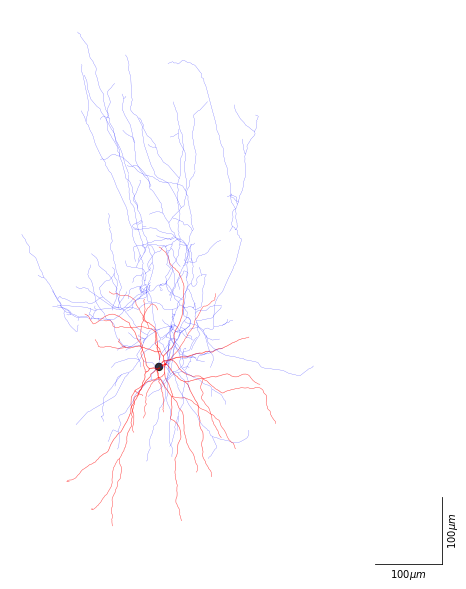

In [7]:
%matplotlib inline
plot_swc(demo_swc_0)
plt.show()

In [8]:
fig_path=Path('morpho_figs')
fig_path.mkdir(exist_ok=True)

In [9]:
swc_iter = filter(lambda p: p.as_posix().endswith('_transformed.swc'),
                  swc_dir.iterdir())
to_plot_swcs = list(swc_iter)

In [12]:
%matplotlib auto
plot_and_save_swcs(to_plot_swcs, fig_path)

  6%|▋         | 9/140 [00:00<00:01, 79.32it/s]

Using matplotlib backend: agg


100%|██████████| 140/140 [04:42<00:00,  2.01s/it]


In [13]:
morpho_cluster_df = pd.read_csv("Gouwens_cluster_morpho.csv")
morpho_cluster_df

,cell_specimen_id,cluster
0,601808698,2
1,602231708,3
2,829170676,7
3,825269133,11
4,821771315,8
...,...,...
120,740875222,10
121,741313892,3
122,741785767,1
123,741796557,8


In [14]:
for cl in set(morpho_cluster_df['cluster']):
    (fig_path/str(cl)).mkdir(exist_ok=True)

In [18]:
morpho_cluster_df['current_path']=morpho_cluster_df['cell_specimen_id'].map(
    lambda c: fig_path/(str(c)+'_transformed.pdf')
)
morpho_cluster_df['target_path'] = morpho_cluster_df.apply(
    lambda row: fig_path/str(row['cluster'])/(
        str(row['cell_specimen_id'])+'_transformed.pdf'),
    axis=1
)
morpho_cluster_df

,cell_specimen_id,cluster,current_path,target_path
0,601808698,2,morpho_figs/601808698_transformed.pdf,morpho_figs/2/601808698_transformed.pdf
1,602231708,3,morpho_figs/602231708_transformed.pdf,morpho_figs/3/602231708_transformed.pdf
2,829170676,7,morpho_figs/829170676_transformed.pdf,morpho_figs/7/829170676_transformed.pdf
3,825269133,11,morpho_figs/825269133_transformed.pdf,morpho_figs/11/825269133_transformed.pdf
4,821771315,8,morpho_figs/821771315_transformed.pdf,morpho_figs/8/821771315_transformed.pdf
...,...,...,...,...
120,740875222,10,morpho_figs/740875222_transformed.pdf,morpho_figs/10/740875222_transformed.pdf
121,741313892,3,morpho_figs/741313892_transformed.pdf,morpho_figs/3/741313892_transformed.pdf
122,741785767,1,morpho_figs/741785767_transformed.pdf,morpho_figs/1/741785767_transformed.pdf
123,741796557,8,morpho_figs/741796557_transformed.pdf,morpho_figs/8/741796557_transformed.pdf


In [22]:
morpho_cluster_df['current_path'].map(lambda p:p.exists()).sum()

116

In [23]:
for cur_p, tar_p in zip(morpho_cluster_df['current_path'], 
                       morpho_cluster_df['target_path']):
    if cur_p.exists():
        cur_p.replace(tar_p)

In [24]:
other_cluster = fig_path/'other'
other_cluster.mkdir(exist_ok=True)
for p in fig_path.iterdir():
    if p.is_file():
        p.replace(other_cluster/p.name)

Some neurons failed to be plotted.

In [10]:
to_plot_names = {p.name for p in to_plot_swcs}
plotted_names = {p.stem+'.swc' for d in fig_path.iterdir() for p in d.iterdir()}
not_plotted_names = to_plot_names-plotted_names

/usr/local/envs/neuron/lib/python3.8/site-packages/neuron_morphology/swc_io.py:50: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  nodes = swc_data.to_dict('record')


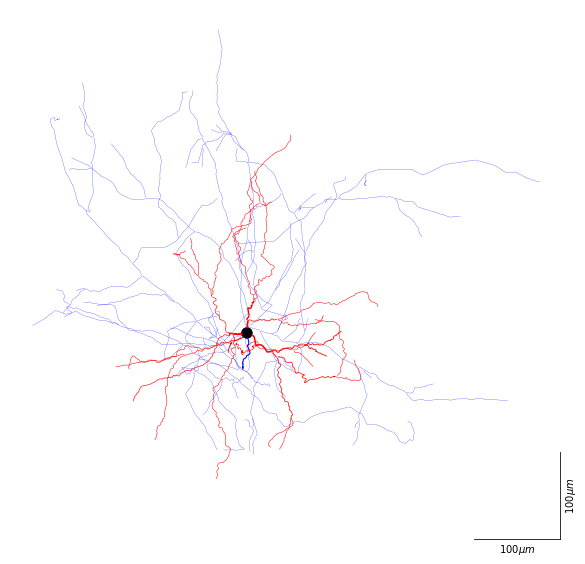

In [11]:
test_swc=swc_dir/not_plotted_names.copy().pop()
test_fig = plot_swc(test_swc, 'neuron_morphology')
test_fig.show()

In [12]:
%matplotlib auto
fig_path_left = Path('morpho_figs_0718')
fig_path_left.mkdir(exist_ok=True)
not_plotted_swcs = [swc_dir/nm for nm in not_plotted_names]
plot_and_save_swcs(not_plotted_swcs, fig_path_left, 'neuron_morphology')

Using matplotlib backend: agg


  0%|          | 0/12 [00:00<?, ?it/s]

## Extract demo morphological features

In [12]:
fe = FeatureExtractor()
fe.register_features(default_features)

In [11]:
demo_swc = next(swc_iter)
demo_morph = morphology_from_swc(demo_swc)
feature_extraction_run = fe.extract(Data(demo_morph))

2021-06-29 17:06:02,831 root         INFO     skipping mark (validation failed): type
2021-06-29 17:06:02,833 root         INFO     skipping mark (validation failed): type
2021-06-29 17:06:02,835 root         INFO     skipping mark (validation failed): type
2021-06-29 17:06:02,845 root         INFO     selected marks: <bound method FeatureExtractionRun.select_marks of <neuron_morphology.feature_extractor.feature_extraction_run.FeatureExtractionRun object at 0x7febbfaebdf0>>
2021-06-29 17:06:02,846 root         INFO     skipping feature: apical_dendrite.compartment.dimension. Found extra marks: ['RequiresApical']
2021-06-29 17:06:02,849 root         INFO     skipping feature: apical_dendrite.tip.dimension. Found extra marks: ['RequiresApical']
2021-06-29 17:06:02,852 root         INFO     skipping feature: apical_dendrite.bifurcation.dimension. Found extra marks: ['RequiresApical']
2021-06-29 17:06:02,853 root         INFO     skipping feature: apical_dendrite.node.dimension. Found extr

In [7]:
%%writefile -a ../morpho_utils.py
def get_hierarchy_items(dic):
    if isinstance(dic, dict):
        for k,v in dic.items():
            if isinstance(v, dict):
                for sub_k,sub_v in get_hierarchy_items(v):
                    yield (str(k)+'.'+sub_k, sub_v)
            elif isinstance(v, list) or isinstance(v, np.ndarray):
                pass
            else:
                yield (str(k),v)

Appending to ../morpho_utils.py


In [50]:
all_features=dict(get_hierarchy_items(feature_extraction_run.results))
all_features

{'axon.compartment.dimension.width': 448.1975465580476,
 'axon.compartment.dimension.height': 564.1427976739803,
 'axon.compartment.dimension.depth': 246.13853470192868,
 'all_neurites.compartment.dimension.width': 448.1975465580476,
 'all_neurites.compartment.dimension.height': 564.1427976739803,
 'all_neurites.compartment.dimension.depth': 246.13853470192868,
 'dendrite.compartment.dimension.width': 448.1975465580476,
 'dendrite.compartment.dimension.height': 564.1427976739803,
 'dendrite.compartment.dimension.depth': 246.13853470192868,
 'basal_dendrite.compartment.dimension.width': 448.1975465580476,
 'basal_dendrite.compartment.dimension.height': 564.1427976739803,
 'basal_dendrite.compartment.dimension.depth': 246.13853470192868,
 'axon.bifurcation.dimension.width': 292.17160838180695,
 'axon.bifurcation.dimension.height': 415.95960479422337,
 'axon.bifurcation.dimension.depth': 189.01248567616182,
 'all_neurites.bifurcation.dimension.width': 292.17160838180695,
 'all_neurites.bi

In [40]:
demo_feature_df=pd.DataFrame(get_hierarchy_items(feature_extraction_run.results),
                             columns=['feature_name', 'feature_value'])
demo_feature_df.to_csv('demo_'+demo_swc.stem+'_morpho_features.csv', index=False)

## Filter required features

In [19]:
# optional use
demo_feature_df = pd.read_csv('demo_601808698_transformed_morpho_features.csv')

In [20]:
required_features = pd.read_excel('电生理形态参数列表第一版.xlsx', engine='openpyxl',
                                 sheet_name=1)['feature_name']
required_features.isin(demo_feature_df['feature_name']).all()

True

In [21]:
required_features

0       axon.compartment.dimension.width
1      axon.compartment.dimension.height
2       axon.compartment.dimension.depth
3       axon.bifurcation.dimension.width
4      axon.bifurcation.dimension.height
5       axon.bifurcation.dimension.depth
6               axon.tip.dimension.width
7              axon.tip.dimension.height
8               axon.tip.dimension.depth
9              axon.node.dimension.width
10            axon.node.dimension.height
11             axon.node.dimension.depth
12                        axon.num_nodes
13                     axon.num_branches
14                         axon.num_tips
15               axon.mean_fragmentation
16                 axon.max_branch_order
17           axon.num_outer_bifurcations
18     axon.mean_bifurcation_angle_local
19    axon.mean_bifurcation_angle_remote
20                     axon.total_length
21               axon.total_surface_area
22                     axon.total_volume
23                 dendrite.total_volume
24              

In [23]:
with open("../morpho_required_features.pkl", 'wb') as f:
    pickle.dump(required_features, f)

In [69]:
feature_extraction_run.results

{'axon.compartment.dimension': {'width': 448.1975465580476,
  'height': 564.1427976739803,
  'depth': 246.13853470192868,
  'min_xyz': array([-232.29859691, -107.43728908,  -66.48944661]),
  'max_xyz': array([215.89894964, 456.70550859, 179.64908809]),
  'bias_xyz': array([ 16.39964727, 349.26821951, 113.15964148])},
 'all_neurites.compartment.dimension': {'width': 448.1975465580476,
  'height': 564.1427976739803,
  'depth': 246.13853470192868,
  'min_xyz': array([-232.29859691, -107.43728908,  -66.48944661]),
  'max_xyz': array([215.89894964, 456.70550859, 179.64908809]),
  'bias_xyz': array([ 16.39964727, 349.26821951, 113.15964148])},
 'dendrite.compartment.dimension': {'width': 448.1975465580476,
  'height': 564.1427976739803,
  'depth': 246.13853470192868,
  'min_xyz': array([-232.29859691, -107.43728908,  -66.48944661]),
  'max_xyz': array([215.89894964, 456.70550859, 179.64908809]),
  'bias_xyz': array([ 16.39964727, 349.26821951, 113.15964148])},
 'basal_dendrite.compartment.di

In [8]:
%%writefile -a ../morpho_utils.py
from neuron_morphology.features.statistics.coordinates import COORD_TYPE_SPECIALIZATIONS
COORD_TYPE_SPECIALIZATIONS
from neuron_morphology.feature_extractor.marked_feature import specialize, nested_specialize

Appending to ../morpho_utils.py


In [10]:
%%writefile -a ../morpho_utils.py
from neuron_morphology.feature_extractor.feature_specialization import (
    AxonSpec, DendriteSpec, AxonCompareSpec, DendriteCompareSpec
)
from neuron_morphology.features.dimension import dimension
from neuron_morphology.features.intrinsic import (
    num_nodes, num_branches, num_tips, mean_fragmentation, max_branch_order
)
from neuron_morphology.features.branching.bifurcations import (
    num_outer_bifurcations, mean_bifurcation_angle_local, mean_bifurcation_angle_remote
)
from neuron_morphology.features.size import (
    total_length,total_surface_area, total_volume, mean_diameter,
    mean_parent_daughter_ratio, max_euclidean_distance
)
from neuron_morphology.features.path import (
    max_path_distance, early_branch_path, mean_contraction
)
from neuron_morphology.features.statistics.overlap import overlap

Appending to ../morpho_utils.py


In [11]:
%%writefile -a ../morpho_utils.py
custom_features = [
    nested_specialize(
        dimension,
        [COORD_TYPE_SPECIALIZATIONS, {AxonSpec}]
    ),
    specialize(num_nodes, {AxonSpec}),
    specialize(num_branches, {AxonSpec}),
    specialize(num_tips, {AxonSpec}),
    specialize(mean_fragmentation, {AxonSpec}),
    specialize(max_branch_order, {AxonSpec}),
    specialize(num_outer_bifurcations, {AxonSpec}),
    specialize(mean_bifurcation_angle_local, {AxonSpec}),
    specialize(mean_bifurcation_angle_remote, {AxonSpec}),
    specialize(total_length, {AxonSpec}),
    specialize(total_surface_area, {AxonSpec}),
    specialize(total_volume, {AxonSpec, DendriteSpec}),
    specialize(mean_diameter, {AxonSpec}),
    specialize(mean_parent_daughter_ratio, {AxonSpec}),
    specialize(max_euclidean_distance, {AxonSpec}),
    max_path_distance,
    early_branch_path,
    mean_contraction,
    nested_specialize(
        overlap,
        [{AxonSpec, DendriteSpec},
        {AxonCompareSpec, DendriteCompareSpec}]
    )
]

Appending to ../morpho_utils.py


In [12]:
%%writefile -a ../morpho_utils.py
basal_extractor = FeatureExtractor()
basal_extractor.register_features(custom_features)

# drop axon.mean_fragmentaion
custom_features_1 = custom_features.copy()
custom_features_1.remove(custom_features_1[4])

opt_extractor = FeatureExtractor()
opt_extractor.register_features(custom_features_1)

Appending to ../morpho_utils.py


In [13]:
%%writefile -a ../morpho_utils.py
def get_required_features(results_dic):
    return filter(lambda kv: kv[0] in required_features.tolist(), 
                     get_hierarchy_items(results_dic))

Appending to ../morpho_utils.py


In [14]:
%%writefile -a ../morpho_utils.py
def get_required_features_from_swcs(swc_iter, extractors=(basal_extractor, opt_extractor)):
    for swc in swc_iter:
        morpho = morphology_from_swc(swc)
        morpho_data = Data(morpho)
        try:
            feature_extraction_run = extractors[0].extract(morpho_data)
        except ZeroDivisionError:
            logging.warning(f'Error extracting {swc}, continue using opt extractor.')
            feature_extraction_run = extractors[1].extract(morpho_data)
        except:
            logging.error(f'Error extracting {swc}, continue next neuron.')
            yield dict()
            continue
        features = dict(get_required_features(feature_extraction_run.results))
        yield features

Appending to ../morpho_utils.py


In [177]:
swc_iter = (Path('swc')/(f'{p}_transformed.swc') for p in id_m['cell_specimen_id'])

In [126]:
all_morpho_features_df = pd.DataFrame(
    {'cell_specimen_id': specimen_id, **result}
    for specimen_id, result in tqdm(
        zip(id_m['cell_specimen_id'], get_required_features_from_swcs(swc_iter)),
        total=id_m.shape[0]
    )
)


  0%|          | 0/140 [00:00<?, ?it/s]2021-06-28 15:15:38,461 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-06-28 15:15:38,463 root         ERROR    Error extracting swc/639862877_transformed.swc, continue next cell.

  1%|          | 1/140 [00:29<1:08:12, 29.44s/it]2021-06-28 15:15:50,843 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-06-28 15:15:50,844 root         ERROR    Error extracting swc/639881631_transformed.swc, continue next cell.

  1%|▏         | 2/140 [00:41<44:38, 19.41s/it]  2021-06-28 15:15:54,674 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-06-28 15:15:54,675 root         ERROR    Error extracting swc/640061596_transformed.swc, continue next cell.

  6%|▌         | 8/140 [08:49<3:27:45, 94.43s/it] 2021-06-28 15:24:08,363 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-06-28 15:24:08,364 root         ERROR    Error extracting swc/

In [12]:
all_morpho_features_df.head()

,cell_specimen_id,axon.compartment.dimension.width,axon.compartment.dimension.height,axon.compartment.dimension.depth,axon.bifurcation.dimension.width,axon.bifurcation.dimension.height,axon.bifurcation.dimension.depth,axon.tip.dimension.width,axon.tip.dimension.height,axon.tip.dimension.depth,...,mean_contraction,axon.dendrite.overlap.above,axon.dendrite.overlap.overlap,axon.dendrite.overlap.below,dendrite.axon.overlap.above,dendrite.axon.overlap.overlap,dendrite.axon.overlap.below,axon.axon.overlap.above,axon.axon.overlap.overlap,axon.axon.overlap.below
0,601790961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,601808698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,602231708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,626153003,433.329271,714.918403,472.280782,302.426051,262.579867,340.741759,434.324426,354.328328,396.824382,...,0.819387,0.213521,0.786479,0.000000,0.00000,0.894941,0.105059,0.0,1.0,0.0
4,639674270,305.783774,681.454578,145.022953,166.569444,82.076149,98.847258,224.335824,582.659692,136.590073,...,0.836762,0.000000,0.923402,0.076598,0.12132,0.878680,0.000000,0.0,1.0,0.0


In [128]:
all_morpho_features_df.isna().sum()

cell_specimen_id                       0
axon.compartment.dimension.width      80
axon.compartment.dimension.height     80
axon.compartment.dimension.depth      80
axon.bifurcation.dimension.width      80
axon.bifurcation.dimension.height     80
axon.bifurcation.dimension.depth      80
axon.tip.dimension.width              80
axon.tip.dimension.height             80
axon.tip.dimension.depth              80
axon.node.dimension.width             80
axon.node.dimension.height            80
axon.node.dimension.depth             80
axon.num_nodes                        80
axon.num_branches                     80
axon.num_tips                         80
axon.mean_fragmentation               80
axon.max_branch_order                 80
axon.num_outer_bifurcations           80
axon.mean_bifurcation_angle_local     80
axon.mean_bifurcation_angle_remote    80
axon.total_length                     80
axon.total_surface_area               80
axon.total_volume                     80
dendrite.total_v

In [129]:
all_morpho_features_df.to_csv('Morpho_features.csv', index=False)

In [79]:
# optional use
all_morpho_features_df = pd.read_csv('Morpho_features.csv')

Handle failed extraction:

In [9]:
failed_morpho_df = all_morpho_features_df[
    all_morpho_features_df.iloc[:,1].isna()
]
failed_ids = id_m[id_m['cell_specimen_id'].isin(failed_morpho_df['cell_specimen_id'])]

In [20]:
failed_ids.head()

,cell_specimen_id,neuron_reconstruction_type,ephys_session_id,transcriptomics_sample_id
0,601790961,full,601790945,PS0817_E1-50_S19
1,601808698,full,601808619,PS0817_E1-50_S26
2,602231708,full,602231628,PS0817_E1-50_S46
8,640061596,full,640061581,SM-GE65C_S125_E1-50
12,644994103,full,644994059,SM-GE64F_S130_E1-50


skip failed parameter

In [131]:
logging.getLogger().setLevel(logging.WARNING)
def get_required_features_from_failed_swcs(swc_iter):
    for swc in swc_iter:
        morpho = morphology_from_swc(swc)
        try:
            feature_extraction_run = extractor.extract(Data(morpho))
        except:
            logging.error(f'Error extracting {swc}, continue next cell.')
            yield dict()
            continue
        features = dict(get_required_features(feature_extraction_run.results))
        yield features

In [134]:
failed_iter = (Path('swc')/(f'{p}_transformed.swc') for p in failed_ids['cell_specimen_id'])

In [135]:
reextracted_df = pd.DataFrame(
    {'cell_specimen_id': specimen_id, **result}
    for specimen_id, result in tqdm(
        zip(failed_ids['cell_specimen_id'], get_required_features_from_swcs(failed_iter)),
        total=failed_ids.shape[0]
    )
)

100%|██████████| 80/80 [7:47:49<00:00, 350.87s/it]   


In [147]:
reextracted_df.to_csv('Morpho_features_rerun_failed.csv', index=False)

In [150]:
reextracted_df.index=failed_ids.index

In [154]:
all_morpho_reextracted=pd.concat([
    all_morpho_features_df[all_morpho_features_df.iloc[:,1].notna()],
    reextracted_df], sort=True
)
all_morpho_reextracted

,axon.axon.overlap.above,axon.axon.overlap.below,axon.axon.overlap.overlap,axon.bifurcation.dimension.depth,axon.bifurcation.dimension.height,axon.bifurcation.dimension.width,axon.compartment.dimension.depth,axon.compartment.dimension.height,axon.compartment.dimension.width,axon.dendrite.overlap.above,...,axon.total_surface_area,axon.total_volume,cell_specimen_id,dendrite.axon.overlap.above,dendrite.axon.overlap.below,dendrite.axon.overlap.overlap,dendrite.total_volume,early_branch_path,max_path_distance,mean_contraction
3,0.0,0.0,1.0,340.741759,262.579867,302.426051,472.280782,714.918403,433.329271,0.213521,...,4119.330382,237.087208,626153003,0.000000,0.105059,0.894941,889.301467,0.860676,554.617390,0.819387
4,0.0,0.0,1.0,98.847258,82.076149,166.569444,145.022953,681.454578,305.783774,0.000000,...,2798.476940,163.659293,639674270,0.121320,0.000000,0.878680,447.460093,0.498719,575.410505,0.836762
5,0.0,0.0,1.0,106.944550,204.156623,118.480424,359.175682,493.747211,475.597508,0.037406,...,2919.142861,173.134039,639708328,0.000000,0.000000,1.000000,873.873113,0.685849,516.062735,0.843306
6,0.0,0.0,1.0,223.179339,375.464943,308.000161,354.486415,483.915333,358.478715,0.000000,...,10721.791839,614.910334,639862877,0.067896,0.381804,0.550300,568.051475,0.698940,741.825303,0.843225
7,0.0,0.0,1.0,193.102824,285.178342,192.983141,339.164839,768.698120,406.871535,0.000000,...,5791.391165,331.281208,639881631,0.622572,0.000000,0.377428,520.942796,0.647695,677.668134,0.851454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0.0,0.0,1.0,266.223179,432.923965,257.210619,317.451241,795.820721,352.014929,0.252035,...,8459.835492,484.023506,829185764,0.000000,0.022129,0.977871,1137.565282,0.775581,761.757030,0.826560
130,0.0,0.0,1.0,164.396924,547.724361,276.816816,245.059127,649.821638,439.484175,0.000000,...,13338.630764,762.969680,844757902,0.535559,0.000652,0.463789,943.142387,0.758877,641.870619,0.875476
131,0.0,0.0,1.0,326.115759,486.938353,322.859532,392.319597,534.841441,457.490220,0.000000,...,13399.923856,1109.217545,847083836,0.554038,0.001284,0.444678,717.254304,0.751979,766.544470,0.861873
132,0.0,0.0,1.0,183.481955,784.466275,448.750838,269.039583,883.221440,672.745142,0.000000,...,8854.941271,542.452745,849535368,0.565882,0.000000,0.434118,697.338452,0.660166,1003.942830,0.842794


extract unfinished morphologies:

In [203]:
unfinished_ids = id_m[
    ~id_m['cell_specimen_id'].isin(all_morpho_reextracted['cell_specimen_id'])
    ]
unfinish_iter = (Path(f'swc/{p}_transformed.swc') for _, p in unfinished_ids['cell_specimen_id'].iteritems())

In [263]:
unfinished_extract_df = pd.DataFrame(
    {'cell_specimen_id': specimen_id, **result}
    for specimen_id, result in tqdm(
        zip(unfinished_ids['cell_specimen_id'], get_required_features_from_swcs(unfinish_iter)),
        total=len(unfinished_ids)
    )
)
unfinished_extract_df

 17%|█▋        | 1/6 [01:43<08:38, 103.70s/it]2021-07-01 16:59:33,498 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-07-01 16:59:33,501 root         WARNING  Error extracting swc/863585604_transformed.swc, continue using opt extractor.
 33%|███▎      | 2/6 [07:28<16:22, 245.52s/it]2021-07-01 17:05:19,068 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-07-01 17:05:19,069 root         WARNING  Error extracting swc/863631899_transformed.swc, continue using opt extractor.
 50%|█████     | 3/6 [12:13<13:10, 263.43s/it]2021-07-01 17:10:00,352 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-07-01 17:10:00,354 root         WARNING  Error extracting swc/870661094_transformed.swc, continue using opt extractor.
 67%|██████▋   | 4/6 [15:30<07:54, 237.47s/it]2021-07-01 17:13:18,931 root         WARNING  feature extraction failed for axon.mean_fragmentation
2021-07-01 17:13:18,932 root         WARNING

,cell_specimen_id,axon.node.dimension.width,axon.node.dimension.height,axon.node.dimension.depth,axon.bifurcation.dimension.width,axon.bifurcation.dimension.height,axon.bifurcation.dimension.depth,axon.compartment.dimension.width,axon.compartment.dimension.height,axon.compartment.dimension.depth,...,mean_contraction,axon.axon.overlap.above,axon.axon.overlap.overlap,axon.axon.overlap.below,dendrite.axon.overlap.above,dendrite.axon.overlap.overlap,dendrite.axon.overlap.below,axon.dendrite.overlap.above,axon.dendrite.overlap.overlap,axon.dendrite.overlap.below
0,862596299,586.489681,492.176328,283.752319,387.616925,341.776079,209.681116,585.486324,518.941066,283.055440,...,0.825116,0.0,1.0,0.0,0.065648,0.934352,0.000000,0.000000,0.987571,0.012429
1,863585604,331.127698,583.697351,598.978629,241.945967,528.165202,517.932914,330.233843,608.448230,597.419250,...,0.858394,0.0,1.0,0.0,0.411006,0.588994,0.000000,0.000000,0.990018,0.009982
2,863631899,600.230802,828.204379,502.142793,452.233195,656.160339,367.981956,599.898434,827.000363,507.424302,...,0.835880,0.0,1.0,0.0,0.471634,0.524577,0.003789,0.000000,1.000000,0.000000
3,870661094,432.093064,405.059077,169.339505,335.527257,266.255445,114.458081,431.287493,404.902789,168.809976,...,0.860983,0.0,1.0,0.0,0.010475,0.792366,0.197159,0.000000,1.000000,0.000000
4,887288382,439.576984,567.746941,148.538721,321.189822,448.238180,120.082786,438.752309,633.564586,146.880474,...,0.828252,0.0,1.0,0.0,0.000000,0.760942,0.239058,0.041618,0.958382,0.000000
5,913928092,737.567401,703.752186,317.278594,643.850183,406.288526,259.147948,736.655579,702.983765,316.507123,...,0.836245,0.0,1.0,0.0,0.131394,0.763992,0.104613,0.000000,1.000000,0.000000


In [264]:
unfinished_extract_df.to_csv('Morpho_features_left.csv')

In [83]:
# optional use
unfinished_extract_df=pd.read_csv('Morpho_features_left.csv', index_col=0)

## Extract layered features

In [50]:
from neuron_morphology.features.layer.reference_layer_depths import DEFAULT_MOUSE_ME_MET_REFERENCE_LAYER_DEPTHS
from Cell.morpho_utils import layer_features, distribution_features, across_cortex_distribution_features, updown_and_move_soma_to_depth
from neuron_morphology.feature_extractor.feature_writer import FeatureWriter

In [35]:
layer_dist_extractor = FeatureExtractor()
layer_dist_extractor.register_features(layer_features+distribution_features)
total_thickness = DEFAULT_MOUSE_ME_MET_REFERENCE_LAYER_DEPTHS['6b'].wm_side
writer = FeatureWriter("me_layer_distribution_features.h5")
logging.getLogger().setLevel(logging.WARNING)
for _, row in tqdm(me_meta_df.iterrows(), total=me_meta_df.shape[0], desc='extracting features'):
    swc = swc_dir/f"{row['cell_specimen_id']}_transformed.swc"
    morpho=morphology_from_swc(swc)
    updown_and_move_soma_to_depth(morpho, total_thickness*row['cell_soma_normalized_depth'])
    data = Data(morpho, reference_layer_depths=DEFAULT_MOUSE_ME_MET_REFERENCE_LAYER_DEPTHS)
    extract_run = layer_dist_extractor.extract(data)
    writer.add_run(swc, extract_run.serialize())
res_layer_df = writer.build_output_table()

extracting features:   0%|          | 0/140 [00:00<?, ?it/s]

In [48]:
res_layer_df.drop(columns=['axon.nodes_distribution', 'axon.length_distribution']).to_csv('me_layer_features_0728.csv')
with open('me_layer_features_0728.pkl', 'wb') as f:
    pickle.dump(res_layer_df, f)
res_length_dist_df = pd.DataFrame(np.stack(res_layer_df['axon.length_distribution'].values), index=res_layer_df.index)
res_length_dist_df.to_csv('me_axon.length_distribution_20bins_0728.csv')
res_node_dist_df = pd.DataFrame(np.stack(res_layer_df['axon.nodes_distribution'].values), index=res_layer_df.index)
res_node_dist_df.to_csv('me_axon.nodes_distribution_20bins_0728.csv')

Inspect Y-dimension features:

In [9]:
from neuron_morphology.feature_extractor.marked_feature import specialize
from neuron_morphology.feature_extractor.feature_specialization import AxonSpec
from neuron_morphology.features.dimension import dimension

dimension_feature = [specialize(dimension, {AxonSpec})]
dimension_extractor = FeatureExtractor()
dimension_extractor.register_features(dimension_feature)
writer = FeatureWriter("me_dimensions.h5")
for _, row in tqdm(me_meta_df.iterrows(), total=me_meta_df.shape[0], desc='extracting dimension'):
    swc = swc_dir/f"{row['cell_specimen_id']}_transformed.swc"
    morpho=morphology_from_swc(swc)
    data = Data(morpho)
    extract_run = dimension_extractor.extract(data)
    writer.add_run(swc, extract_run.serialize())

In [16]:
dimension_res_df = writer.build_output_table()

y_lims_df = pd.DataFrame({'Cell': swc,
                          'axon.dimension.height': row['axon.dimension.height'],
                          'axon.dimension.min_y': row['axon.dimension.min_xyz'][1],
                          'axon.dimension.max_y': row['axon.dimension.max_xyz'][1]
                         }
                         for swc, (_, row) in zip(swcs, dimension_res_df.iterrows()))
y_lims_df.head()

,Cell,axon.dimension.height,axon.dimension.min_y,axon.dimension.max_y
0,swc/601790961_transformed.swc,643.481855,-141.295882,502.185974
1,swc/601808698_transformed.swc,564.497951,-107.777268,456.720683
2,swc/602231708_transformed.swc,545.545944,-99.750696,445.795248
3,swc/626153003_transformed.swc,301.637886,-170.216001,131.421885
4,swc/639674270_transformed.swc,267.880407,-259.681439,8.198968


In [17]:
y_lims_df.to_csv('me_axon_height.csv')

Extract depth histogram features across cortex:

In [51]:
cortex_dist_extractor = FeatureExtractor()
cortex_dist_extractor.register_features(across_cortex_distribution_features)
depth_range = (0, DEFAULT_MOUSE_ME_MET_REFERENCE_LAYER_DEPTHS['6b'].wm_side)
writer = FeatureWriter("me_layer_distribution_features.h5")
logging.getLogger().setLevel(logging.WARNING)
for _, row in tqdm(me_meta_df.iterrows(), total=me_meta_df.shape[0], desc='extract histogram features across cortex'):
    swc = swc_dir / f"{row['cell_specimen_id']}_transformed.swc"
    morpho = morphology_from_swc(swc)
    updown_and_move_soma_to_depth(morpho, total_thickness * row['cell_soma_normalized_depth'])
    data = Data(morpho, cortex_depth_range=depth_range)
    extract_run = cortex_dist_extractor.extract(data)
    writer.add_run(swc, extract_run.serialize())
res_cortex_dist_df = writer.build_output_table()

/usr/local/envs/neuron/lib/python3.8/site-packages/neuron_morphology/feature_extractor/feature_writer.py:54: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  self.heavy_file = h5py.File(self.heavy_path, driver="core")


extract histogram features across cortex:   0%|          | 0/140 [00:00<?, ?it/s]

/usr/local/envs/neuron/lib/python3.8/site-packages/neuron_morphology/swc_io.py:50: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  nodes = swc_data.to_dict('record')


In [54]:
res_cortex_length_dist_df = pd.DataFrame(np.stack(res_cortex_dist_df['axon.across_cortex.length_distribution'].values), index=res_cortex_dist_df.index)
res_cortex_nodes_dist_df = pd.DataFrame(np.stack(res_cortex_dist_df['axon.across_cortex.nodes_distribution'].values), index=res_cortex_dist_df.index)
res_cortex_length_dist_df.to_csv('axon.across_cortex.length_distribution-0801.csv')
res_cortex_nodes_dist_df.to_csv('axon.across_cortex.nodes_distribution-0801.csv')

# Convert format

## Inspect axon

Whether the failed morphologies have axons?

In [2]:
from neuron_morphology.constants import *

In [3]:
morph_type_map = {SOMA: 'soma', AXON: 'axon', BASAL_DENDRITE: 'dendrite'}

In [11]:
get_node_types = lambda morph: set(n['type'] for n in morph.nodes())

In [12]:
failed_iter = (Path('swc')/(f'{p}_transformed.swc') for p in failed_ids['cell_specimen_id'])
node_type_df = pd.DataFrame({
    'cell_specimen_id': specimen_id,
    'swc_path': path,
    'node_types': get_node_types(morphology_from_swc(path))
} for specimen_id, path in tqdm(zip(failed_ids['cell_specimen_id'], failed_iter),
                               total = failed_ids.shape[0]))


  0%|          | 0/80 [00:00<?, ?it/s]/usr/local/envs/neuron/lib/python3.8/site-packages/pandas/core/frame.py:1549: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  warnings.warn(

100%|██████████| 80/80 [00:26<00:00,  3.01it/s]


In [13]:
node_type_df

,cell_specimen_id,swc_path,node_types
0,601790961,swc/601790961_transformed.swc,"{1, 2, 3}"
1,601808698,swc/601808698_transformed.swc,"{1, 2, 3}"
2,602231708,swc/602231708_transformed.swc,"{1, 2, 3}"
3,640061596,swc/640061596_transformed.swc,"{1, 2, 3}"
4,644994103,swc/644994103_transformed.swc,"{1, 2, 3}"
...,...,...,...
75,829185764,swc/829185764_transformed.swc,"{1, 2, 3}"
76,844757902,swc/844757902_transformed.swc,"{1, 2, 3}"
77,847083836,swc/847083836_transformed.swc,"{1, 2, 3}"
78,849535368,swc/849535368_transformed.swc,"{1, 2, 3}"


All failed neurons have soma, axon, dendrite node.

In [16]:
node_type_df['node_types'] = node_type_df['node_types'].map(
    lambda t:{morph_type_map.get(t_) for t_ in t}
)

In [18]:
node_type_df.to_csv('Node types for failed neurons.csv')

## Convert ASC to SWC

In [18]:
from morph_tool import convert, MorphToolException

In [93]:
asc_path = Path('Gouwes_repaired_morpho_ASC')
asc_iter = asc_path.iterdir()
total_asc_size = len(list(asc_iter))

In [98]:
convert_out_path=Path('swc_from_asc')
convert_out_path.mkdir(exist_ok=True)

In [97]:
asc_iter = asc_path.iterdir()
logger = logging.getLogger()
for asc_file in tqdm(asc_iter, total=total_asc_size):
    swc_out = convert_out_path/(asc_file.stem+'.swc')
    if not swc_out.exists():
        try:
            convert(asc_file, swc_out)
        except MorphToolException:
            convert(asc_file, swc_out, sanitize=True)
        except:
            logger.error(f'convert {swc_out} failed.')
    else:
        continue

  0%|          | 0/139 [00:00<?, ?it/s]2021-07-03 14:46:01,099 morph_tool.converter INFO     Original soma type: SomaType.SOMA_UNDEFINED
2021-07-03 14:46:01,150 morph_tool.converter INFO     Original soma type: SomaType.SOMA_UNDEFINED
2021-07-03 14:46:01,269 morph_tool.converter INFO     Final NEURON soma surface check was skipped probably because BluePyOpt or NEURON is not installed
 19%|█▉        | 27/139 [00:00<00:01, 98.29it/s]2021-07-03 14:46:01,321 morph_tool.converter INFO     Original soma type: SomaType.SOMA_UNDEFINED
2021-07-03 14:46:01,398 morph_tool.converter INFO     Final NEURON soma surface check was skipped probably because BluePyOpt or NEURON is not installed
2021-07-03 14:46:01,495 morph_tool.converter INFO     Original soma type: SomaType.SOMA_UNDEFINED
2021-07-03 14:46:01,627 morph_tool.converter INFO     Final NEURON soma surface check was skipped probably because BluePyOpt or NEURON is not installed
2021-07-03 14:46:01,737 morph_tool.converter INFO     Original so